<a href="https://colab.research.google.com/github/raghunadh-eva/eva6/blob/master/S7_ASSIGNMENT/MODELS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Basic setup block**


*   Load the required utils/libraries
*   Setup the transformations needed to load the data
*   Split the input data into train and test
*   Create the train and test data objects





In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, utils
%matplotlib inline
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
!pip install torchsummary
from torchsummary import summary
import numpy as np

In [2]:
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914,0.4822,0.4465), (0.247,0.2435,0.2616))
                                       #transforms.RandomRotation((-7.0,7.0),fill=(0))
                                       #Ideally use mean - adding #0 since MNIST dark pixels and no-information around the borders
                                       #transforms.ColorJitter(brightness = 0.1, contrast= 0.1, saturation = 0.1, hue =0.1),
                                       #transforms.Resize((28,28)) #should be before converting to Tensor logically
                                       ])
test_transforms  = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914,0.4822,0.4465), (0.247,0.2435,0.2616))
                                       #transforms.RandomRotation((-7.0,7.0),fill=(0,)), #Ideally use mean - adding #0 since MNIST dark pixels and no-information around the borders
                                       #transforms.ColorJitter(brightness = 0.1, contrast= 0.1, saturation = 0.1, hue =0.1)
                                       #transforms.Resize((28,28)) #should be before converting to Tensor logically
                                      ])

In [3]:
train = datasets.CIFAR10('./data', train=True,  download=True, transform=train_transforms)
test =  datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
#Always start with same random set everytime
SEED = 1

#Is GPU ?
cuda = torch.cuda.is_available()

print('CUDA Available?',cuda)

#what happens when SEED = 2 ?
torch.manual_seed(SEED)

#set the seed for GPU device as well
if cuda:
  torch.cuda.manual_seed(SEED)

device = torch.device("cuda" if cuda else "cpu")
print(device)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
#Why change batch_size for CPU - since it should not matter

train_loader = torch.utils.data.DataLoader(train, **dataloader_args)


test_loader  = torch.utils.data.DataLoader(test, **dataloader_args)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

##Why shuffle=false in the example provided ?

CUDA Available? True
cuda


**Visualize the input data with image standardization**


 deer   car horse   dog


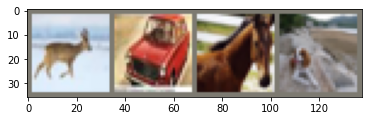

In [5]:
image_loader = torch.utils.data.DataLoader(train, shuffle=True,batch_size=4)

def imshow(img):
    npimg = img.numpy()
    npimg[0] = (npimg[0] * 0.247) + 0.4914
    npimg[1] = (npimg[1] * 0.2435) + 0.4822
    npimg[2] = (npimg[2] * 0.2616) + 0.4465
    #we can use this directly but simply converting to tensor and converting back
    timg = torch.from_numpy(npimg)
    nimg = timg.numpy()
    plt.imshow(np.transpose(nimg, (1, 2, 0)))

# get some random training images
dataiter = iter(image_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
#print(classes[labels[10]])
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

**Visualize the input data without image standardization**



In [6]:
#Comment this block from CODE2 onwards
train_nonorm_transforms = transforms.Compose([
                                       transforms.ToTensor()
                                       #transforms.Normalize((0.1307,), (0.3081,))
                                       #transforms.RandomRotation((-7.0,7.0),fill=(0,)), #Ideally use mean - adding #0 since MNIST dark pixels and no-information around the borders
                                       #transforms.ColorJitter(brightness = 0.1, contrast= 0.1, saturation = 0.1, hue =0.1),
                                       #transforms.Resize((28,28)) #should be before converting to Tensor logically
                                       ])
test_nonorm_transforms  = transforms.Compose([
                                       transforms.ToTensor()
                                       #transforms.Normalize((0.1307,), (0.3081,))
                                       #transforms.RandomRotation((-7.0,7.0),fill=(0,)), #Ideally use mean - adding #0 since MNIST dark pixels and no-information around the borders
                                       #transforms.ColorJitter(brightness = 0.1, contrast= 0.1, saturation = 0.1, hue =0.1)
                                       #transforms.Resize((28,28)) #should be before converting to Tensor logically
                                      ])
train_nonorm = datasets.CIFAR10('./data_nonorm', train=True,  download=True, transform=train_nonorm_transforms)
test_nonorm =  datasets.CIFAR10('./data_nonorm', train=False, download=True, transform=test_nonorm_transforms)
train_loader_nonorm = torch.utils.data.DataLoader(train_nonorm, **dataloader_args)
test_loader_nonorm  = torch.utils.data.DataLoader(test_nonorm, **dataloader_args)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
chsum = 0
from tqdm import tqdm
#pbar = tqdm(train_loader_nonorm)

for index, (data,target) in enumerate(train_loader_nonorm):
    chsum += data.sum(dim=(0,2,3),keepdim=True)

mean = chsum / (len(train_nonorm) * 32 *32)

chsum = None
for index, (data,target) in enumerate(train_loader_nonorm):
  if index == 0:
    print(data.min(),data.max())
    chsum = (data - mean).pow(2).sum(dim=(0,2,3),keepdim=True)
  else:
    chsum += (data - mean).pow(2).sum(dim=(0,2,3),keepdim=True)

std = torch.sqrt(chsum/(len(train_nonorm) * 32 * 32))
print("Traindata Mean",mean)
print("Traindata std dev",std)

chsum = 0
from tqdm import tqdm
pbar = tqdm(test_loader_nonorm)

for index, (data,target) in enumerate(test_loader_nonorm):
    chsum += data.sum(dim=(0,2,3),keepdim=True)

mean = chsum / (len(test_nonorm) * 32 *32)

chsum = None
for index, (data,target) in enumerate(test_loader_nonorm):
  if index == 0:
    chsum = (data - mean).pow(2).sum(dim=(0,2,3),keepdim=True)
  else:
    chsum += (data - mean).pow(2).sum(dim=(0,2,3),keepdim=True)

std = torch.sqrt(chsum/(len(test_nonorm) * 32 * 32))
print("Test data Mean",mean)
print("Test data std dev",std)

tensor(0.) tensor(1.)


  0%|          | 0/79 [00:00<?, ?it/s]

Traindata Mean tensor([[[[0.4914]],

         [[0.4822]],

         [[0.4465]]]])
Traindata std dev tensor([[[[0.2470]],

         [[0.2435]],

         [[0.2616]]]])
Test data Mean tensor([[[[0.4942]],

         [[0.4851]],

         [[0.4504]]]])
Test data std dev tensor([[[[0.2467]],

         [[0.2429]],

         [[0.2616]]]])


plane


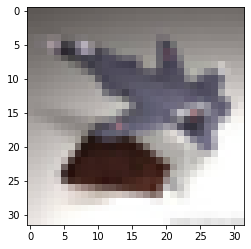

In [8]:
dataiter = iter(train_loader_nonorm)
images, labels = dataiter.next()

def imshow_nonorm(img):
    img = img     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
# show images
imshow_nonorm(torchvision.utils.make_grid(images[10]))

print(classes[labels[10]])
#print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [9]:
dropout_perc = 0.05

**####Batch Normalization + L1 LOSS**

In [10]:
class BatchNormNet(nn.Module):
    def __init__(self):
        super(BatchNormNet, self).__init__()

        #BLOCK C1
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        ) # output_size = 32 ; #Receptive field = 3x3

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        ) # output_size = 32; #Receptive field = 5x5
        
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        ) # output_size = 32; #Receptive field = 7x7

        #BLOCK C1 TRANSITION
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 32; #Receptive field = 7x7

        #self.pool1 = nn.MaxPool2d(2, 2) # output_size = 16 ; #Receptive field = 8x8
        #Drop maxPooling and use strided convolution
        self.pool1 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), stride=2, padding=1, bias=False),
        )
        #BLOCK C2
        
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        ) # output_size = 16; #Receptive field = 5x5
        
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        ) # output_size = 16; #Receptive field = 5x5

        #BLOCK C2 TRANSITION
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 16; #Receptive field = 5x5
        
        #BLOCK C3
        
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        ) # output_size = 16; #Receptive field = 5x5
        
        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        ) # output_size = 16; #Receptive field = 5x5

        #BLOCK C3 TRANSITION
        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 16; #Receptive field = 5x5
        
        
        #self.pool2 = nn.MaxPool2d(2, 2) # output_size = 8 ; #Receptive field = 8x8
        self.pool2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), stride=2, padding=1, bias=False),
        )
        #BLOCK C4
        
        self.convblock11 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        ) # output_size = 8; #Receptive field = 5x5
        
        self.convblock12 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        ) # output_size = 8; #Receptive field = 5x5

        #BLOCK C4 TRANSITION
        #self.convblock13 = nn.Sequential(
        #    nn.Conv2d(in_channels=64, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
        #) # output_size = 8; #Receptive field = 5x5
                 
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=8)
        ) # output_size = 1

        self.convblock14 = nn.Sequential(
            nn.Linear(64,10,0)
        )

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.pool1(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.convblock10(x)
        x = self.pool2(x)
        x = self.convblock11(x)
        x = self.convblock12(x)
        #x = self.convblock13(x)
        x = self.gap(x)
        
        x = x.view(x.size(0), -1)
        x = self.convblock14(x)
   
        return F.log_softmax(x, dim=-1)

In [11]:
model = BatchNormNet().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           4,608
       BatchNorm2d-6           [-1, 32, 32, 32]              64
              ReLU-7           [-1, 32, 32, 32]               0
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          18,432
      BatchNorm2d-10           [-1, 64, 32, 32]             128
             ReLU-11           [-1, 64, 32, 32]               0
          Dropout-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 16, 32, 32]           1,024
           Conv2d-14           [-1, 16,

####LayerNorm Normalization + L1 LOSS

In [12]:
class LayerNormNet(nn.Module):
    def __init__(self):
        super(LayerNormNet, self).__init__()

        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.GroupNorm(1,10),
            nn.Dropout(dropout_perc)
        ) # output_size = 26 ; #Receptive field = 3x3

        #CT1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=18, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.GroupNorm(1,18),
            nn.Dropout(dropout_perc)
        ) # output_size = 24; #Receptive field = 5x5

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=18, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24; #Receptive field = 5x5

        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12 ; #Receptive field = 6x6

        #CT2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.GroupNorm(1,16),
            nn.Dropout(dropout_perc)
        ) # output_size = 10 ;  #Receptive field = 10x10

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.GroupNorm(1,20),            
            nn.Dropout(dropout_perc)
        ) # output_size = 8 ; #Receptive field = 14x14

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 8 ; #Receptive field = 14x14
     
        #CT3
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(3, 3), padding=0, bias=False), 
            nn.ReLU(),
            nn.GroupNorm(1,32),
            nn.Dropout(dropout_perc)          
        ) # output_size = 6 ; #Receptive field = 18x18
                 
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
        )

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.gap(x)        
        x = self.convblock9(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

**`####Group normalization network + L1 LOSS`**

In [13]:
class GroupNormNet(nn.Module):
    def __init__(self):
        super(GroupNormNet, self).__init__()

        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.GroupNorm(2,10),
            nn.Dropout(dropout_perc)
        ) # output_size = 26 ; #Receptive field = 3x3

        #CT1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=18, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.GroupNorm(3,18),
            nn.Dropout(dropout_perc)
        ) # output_size = 24; #Receptive field = 5x5

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=18, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24; #Receptive field = 5x5

        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12 ; #Receptive field = 6x6

        #CT2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.GroupNorm(2,16),
            nn.Dropout(dropout_perc)
        ) # output_size = 10 ;  #Receptive field = 10x10

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.GroupNorm(2,20),            
            nn.Dropout(dropout_perc)
        ) # output_size = 8 ; #Receptive field = 14x14

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 8 ; #Receptive field = 14x14
     
        #CT3
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(3, 3), padding=0, bias=False), 
            nn.ReLU(),
            nn.GroupNorm(2,32),
            nn.Dropout(dropout_perc)          
        ) # output_size = 6 ; #Receptive field = 18x18
                 
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
        )

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.gap(x)        
        x = self.convblock9(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [30]:
from tqdm import tqdm

test_fail_data = []
test_fail_target = []
test_losses = []
test_acc = []
train_acc = []
train_losses = []

loss_function = nn.CrossEntropyLoss()

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)

  l1_lamda = 0.0001
  
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    #Cross entropy loss
    #loss = F.nll_loss(y_pred, target)
    loss = loss_function(y_pred,target)
    print(loss)
    #

    ##Add L1 Loss
    l1 = 0
    for p in model.parameters():
      p_tensor = torch.sum(torch.abs(p))
      l1 += p_tensor

    loss = loss + l1_lamda * l1
    
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    test_fail_data = []
    test_fail_target = []

    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            for i,x in enumerate(pred.eq(target.view_as(pred))):
              if not x:
                test_fail_data.append(data[i])
                test_fail_target.append(target[i])
                print(target[i])

    test_losses.append(test_loss)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

    return test_losses, test_acc, test_fail_data, test_fail_target;

**####Block to pass argment and call the Model**

Pass the model to be Invoked based on Input Argument

In [22]:
def main(input_model_type,EPOCHS):
  if input_model_type == 0:
    model = BatchNormNet().to(device)
    run_train_test(model,EPOCHS,input_model_type)
  elif input_model_type == 1:
    model = LayerNormNet().to(device)
    run_train_test(model,EPOCHS,input_model_type)
  elif input_model_type == 2:
    model = GroupNormNet().to(device)
    run_train_test(model,EPOCHS,input_model_type)
  else:
    print("Invalid input for input_model_type",input_model_type)
    print("Supported values are 0 = Batch Norm,1 = Layer Norm,2 = Group Norm")

def run_train_test(model,EPOCHS,input_model_type):
  summary(model, input_size=(3, 32, 32))
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

  for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    
    train(model, device, train_loader, optimizer, epoch)
    
    test_losses, test_acc, test_fail_data, test_fail_target = test(model, device, test_loader)
  
  #print(test_fail_data)
  fig, axs = plt.subplots(1, 2)
  if input_model_type == 0:
    fig.suptitle('Model Type: Batch normalization')
  if input_model_type == 1:
    fig.suptitle('Model Type: Layer normalization')
  if input_model_type == 2:
    fig.suptitle('Model Type: Group normalization')
  
  axs[0].set_title('Test/Validation Loss Graph')
  axs[0].set_xticks(np.arange(1,EPOCHS+1))
  #axs[0].xlabel('Test/Validation Loss Graph')
  #axs[0].ylabel('LOSS')
  axs[1].set_title('Test/Validation Accuracy Graph')
  axs[1].set_xticks(np.arange(1,EPOCHS+1))
  #axs[1].xlabel('Test/Validation Accuracy Graph')
  #axs[1].ylabel('Accuracy')
  
  axs[0].plot(test_losses)
  axs[1].plot(test_acc)

  test_10_images = []
  for i in range(0,10):
    test_10_images.append(test_fail_data[i])
  
  test_10_images_target = []
  for i in range(0,10):
    test_10_images_target.append(test_fail_target[i])

  for i in range(0,10):
    print(classes[test_10_images_target[i]])
  
  grid = torchvision.utils.make_grid(torch.stack(test_10_images).cpu(), nrow=5)
  plt.figure(figsize=(15,15))
  plt.imshow(np.transpose(grid, (1,2,0)))

**####Call to main function**

main(input_model_type,EPOCHS)

input_model_type:

Supported values are

0 = Train a model with Batch normalization

1 = Train a model with Layer normalization

2 = Train a model with Group Normalization

EPOCHS: num_epochs








  0%|          | 0/391 [00:00<?, ?it/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           4,608
       BatchNorm2d-6           [-1, 32, 32, 32]              64
              ReLU-7           [-1, 32, 32, 32]               0
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          18,432
      BatchNorm2d-10           [-1, 64, 32, 32]             128
             ReLU-11           [-1, 64, 32, 32]               0
          Dropout-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 16, 32, 32]           1,024
           Conv2d-14           [-1, 16,







Loss=2.7191989421844482 Batch_id=0 Accuracy=7.81:   0%|          | 0/391 [00:00<?, ?it/s]





Loss=2.7191989421844482 Batch_id=0 Accuracy=7.81:   0%|          | 1/391 [00:00<01:34,  4.14it/s]





Loss=2.6811139583587646 Batch_id=1 Accuracy=7.81:   0%|          | 1/391 [00:00<01:34,  4.14it/s]


tensor(2.2998, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.3217, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=2.702932119369507 Batch_id=2 Accuracy=8.85:   0%|          | 1/391 [00:00<01:34,  4.14it/s] 





Loss=2.702932119369507 Batch_id=2 Accuracy=8.85:   1%|          | 3/391 [00:00<01:13,  5.30it/s]





Loss=2.692835807800293 Batch_id=3 Accuracy=8.59:   1%|          | 3/391 [00:00<01:13,  5.30it/s]





Loss=2.6814873218536377 Batch_id=4 Accuracy=8.28:   1%|          | 3/391 [00:00<01:13,  5.30it/s]





Loss=2.6814873218536377 Batch_id=4 Accuracy=8.28:   1%|▏         | 5/391 [00:00<00:58,  6.55it/s]





Loss=2.66713285446167 Batch_id=5 Accuracy=9.11:   1%|▏         | 5/391 [00:00<00:58,  6.55it/s]  

tensor(2.3116, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.3003, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.2860, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.2766, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=2.657743215560913 Batch_id=6 Accuracy=10.16:   1%|▏         | 5/391 [00:00<00:58,  6.55it/s]





Loss=2.657743215560913 Batch_id=6 Accuracy=10.16:   2%|▏         | 7/391 [00:00<00:47,  8.06it/s]





Loss=2.671067237854004 Batch_id=7 Accuracy=10.64:   2%|▏         | 7/391 [00:00<00:47,  8.06it/s]





Loss=2.6593382358551025 Batch_id=8 Accuracy=11.46:   2%|▏         | 7/391 [00:00<00:47,  8.06it/s]





Loss=2.6593382358551025 Batch_id=8 Accuracy=11.46:   2%|▏         | 9/391 [00:00<00:39,  9.61it/s]





Loss=2.6499807834625244 Batch_id=9 Accuracy=11.88:   2%|▏         | 9/391 [00:00<00:39,  9.61it/s]





Loss=2.6417486667633057 Batch_id=10 Accuracy=12.00:   2%|▏         | 9/391 [00:00<00:39,  9.61it/s]







tensor(2.2900, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.2783, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.2690, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.2609, device='cuda:0', grad_fn=<NllLossBackward>)


Loss=2.6417486667633057 Batch_id=10 Accuracy=12.00:   3%|▎         | 11/391 [00:00<00:33, 11.35it/s]





Loss=2.6227638721466064 Batch_id=11 Accuracy=12.11:   3%|▎         | 11/391 [00:00<00:33, 11.35it/s]





Loss=2.620579719543457 Batch_id=12 Accuracy=12.80:   3%|▎         | 11/391 [00:00<00:33, 11.35it/s] 





Loss=2.620579719543457 Batch_id=12 Accuracy=12.80:   3%|▎         | 13/391 [00:00<00:30, 12.23it/s]





Loss=2.595837354660034 Batch_id=13 Accuracy=13.11:   3%|▎         | 13/391 [00:01<00:30, 12.23it/s]

tensor(2.2419, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.2398, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.2151, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.2161, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=2.596691370010376 Batch_id=14 Accuracy=13.28:   3%|▎         | 13/391 [00:01<00:30, 12.23it/s]





Loss=2.596691370010376 Batch_id=14 Accuracy=13.28:   4%|▍         | 15/391 [00:01<00:27, 13.53it/s]





Loss=2.5790886878967285 Batch_id=15 Accuracy=13.82:   4%|▍         | 15/391 [00:01<00:27, 13.53it/s]





Loss=2.5808773040771484 Batch_id=16 Accuracy=14.29:   4%|▍         | 15/391 [00:01<00:27, 13.53it/s]





Loss=2.5808773040771484 Batch_id=16 Accuracy=14.29:   4%|▍         | 17/391 [00:01<00:27, 13.78it/s]





Loss=2.515964984893799 Batch_id=17 Accuracy=14.84:   4%|▍         | 17/391 [00:01<00:27, 13.78it/s] 







tensor(2.1985, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.2004, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1355, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1502, device='cuda:0', grad_fn=<NllLossBackward>)


Loss=2.530614137649536 Batch_id=18 Accuracy=15.42:   4%|▍         | 17/391 [00:01<00:27, 13.78it/s]





Loss=2.530614137649536 Batch_id=18 Accuracy=15.42:   5%|▍         | 19/391 [00:01<00:25, 14.52it/s]





Loss=2.548222541809082 Batch_id=19 Accuracy=15.74:   5%|▍         | 19/391 [00:01<00:25, 14.52it/s]





Loss=2.4889276027679443 Batch_id=20 Accuracy=16.00:   5%|▍         | 19/391 [00:01<00:25, 14.52it/s]





Loss=2.4889276027679443 Batch_id=20 Accuracy=16.00:   5%|▌         | 21/391 [00:01<00:24, 15.25it/s]





Loss=2.561002254486084 Batch_id=21 Accuracy=16.23:   5%|▌         | 21/391 [00:01<00:24, 15.25it/s] 





Loss=2.50376558303833 Batch_id=22 Accuracy=16.51:   5%|▌         | 21/391 [00:01<00:24, 15.25it/s] 

tensor(2.1679, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1087, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1808, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1237, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=2.50376558303833 Batch_id=22 Accuracy=16.51:   6%|▌         | 23/391 [00:01<00:23, 15.65it/s]





Loss=2.4703540802001953 Batch_id=23 Accuracy=16.63:   6%|▌         | 23/391 [00:01<00:23, 15.65it/s]





Loss=2.422417163848877 Batch_id=24 Accuracy=17.03:   6%|▌         | 23/391 [00:01<00:23, 15.65it/s] 





Loss=2.422417163848877 Batch_id=24 Accuracy=17.03:   6%|▋         | 25/391 [00:01<00:22, 16.05it/s]





Loss=2.424194097518921 Batch_id=25 Accuracy=17.04:   6%|▋         | 25/391 [00:01<00:22, 16.05it/s]





Loss=2.4322609901428223 Batch_id=26 Accuracy=17.13:   6%|▋         | 25/391 [00:01<00:22, 16.05it/s]





Loss=2.4322609901428223 Batch_id=26 Accuracy=17.13:   7%|▋         | 27/391 [00:01<00:21, 16.81it/s]

tensor(2.0903, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0425, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0443, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0524, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=2.4077510833740234 Batch_id=27 Accuracy=17.41:   7%|▋         | 27/391 [00:01<00:21, 16.81it/s]





Loss=2.403357982635498 Batch_id=28 Accuracy=17.73:   7%|▋         | 27/391 [00:01<00:21, 16.81it/s] 





Loss=2.403357982635498 Batch_id=28 Accuracy=17.73:   7%|▋         | 29/391 [00:01<00:22, 15.87it/s]





Loss=2.4547197818756104 Batch_id=29 Accuracy=17.89:   7%|▋         | 29/391 [00:01<00:22, 15.87it/s]

tensor(2.0280, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0237, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0751, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1108, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=2.4904022216796875 Batch_id=30 Accuracy=17.92:   7%|▋         | 29/391 [00:02<00:22, 15.87it/s]





Loss=2.4904022216796875 Batch_id=30 Accuracy=17.92:   8%|▊         | 31/391 [00:02<00:22, 16.15it/s]





Loss=2.4756078720092773 Batch_id=31 Accuracy=18.02:   8%|▊         | 31/391 [00:02<00:22, 16.15it/s]





Loss=2.3669376373291016 Batch_id=32 Accuracy=18.21:   8%|▊         | 31/391 [00:02<00:22, 16.15it/s]





Loss=2.3669376373291016 Batch_id=32 Accuracy=18.21:   8%|▊         | 33/391 [00:02<00:22, 15.62it/s]





Loss=2.378835439682007 Batch_id=33 Accuracy=18.41:   8%|▊         | 33/391 [00:02<00:22, 15.62it/s] 

tensor(2.0961, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9875, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9995, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9269, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=2.3062222003936768 Batch_id=34 Accuracy=18.64:   8%|▊         | 33/391 [00:02<00:22, 15.62it/s]





Loss=2.3062222003936768 Batch_id=34 Accuracy=18.64:   9%|▉         | 35/391 [00:02<00:21, 16.30it/s]





Loss=2.3423430919647217 Batch_id=35 Accuracy=18.77:   9%|▉         | 35/391 [00:02<00:21, 16.30it/s]





Loss=2.326772451400757 Batch_id=36 Accuracy=18.98:   9%|▉         | 35/391 [00:02<00:21, 16.30it/s] 





Loss=2.326772451400757 Batch_id=36 Accuracy=18.98:   9%|▉         | 37/391 [00:02<00:21, 16.46it/s]





Loss=2.3600287437438965 Batch_id=37 Accuracy=19.16:   9%|▉         | 37/391 [00:02<00:21, 16.46it/s]

tensor(1.9631, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9476, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9809, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9293, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=2.3083040714263916 Batch_id=38 Accuracy=19.33:   9%|▉         | 37/391 [00:02<00:21, 16.46it/s]





Loss=2.3083040714263916 Batch_id=38 Accuracy=19.33:  10%|▉         | 39/391 [00:02<00:21, 16.41it/s]





Loss=2.23280668258667 Batch_id=39 Accuracy=19.59:  10%|▉         | 39/391 [00:02<00:21, 16.41it/s]  





Loss=2.374966621398926 Batch_id=40 Accuracy=19.72:  10%|▉         | 39/391 [00:02<00:21, 16.41it/s]





Loss=2.374966621398926 Batch_id=40 Accuracy=19.72:  10%|█         | 41/391 [00:02<00:21, 16.62it/s]





Loss=2.3428189754486084 Batch_id=41 Accuracy=19.85:  10%|█         | 41/391 [00:02<00:21, 16.62it/s]





Loss=2.3870139122009277 Batch_id=42 Accuracy=19.88:  10%|█         | 41/391 [00:02<00:21, 16.62it/s]

tensor(1.8538, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9961, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9640, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0082, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=2.3870139122009277 Batch_id=42 Accuracy=19.88:  11%|█         | 43/391 [00:02<00:20, 16.94it/s]





Loss=2.4161736965179443 Batch_id=43 Accuracy=20.05:  11%|█         | 43/391 [00:02<00:20, 16.94it/s]





Loss=2.251835584640503 Batch_id=44 Accuracy=20.14:  11%|█         | 43/391 [00:02<00:20, 16.94it/s] 





Loss=2.251835584640503 Batch_id=44 Accuracy=20.14:  12%|█▏        | 45/391 [00:02<00:21, 16.42it/s]





Loss=2.267817258834839 Batch_id=45 Accuracy=20.28:  12%|█▏        | 45/391 [00:02<00:21, 16.42it/s]

tensor(2.0375, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8732, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8892, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8898, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=2.268277645111084 Batch_id=46 Accuracy=20.48:  12%|█▏        | 45/391 [00:03<00:21, 16.42it/s]





Loss=2.268277645111084 Batch_id=46 Accuracy=20.48:  12%|█▏        | 47/391 [00:03<00:21, 16.37it/s]





Loss=2.299943208694458 Batch_id=47 Accuracy=20.48:  12%|█▏        | 47/391 [00:03<00:21, 16.37it/s]





Loss=2.3092708587646484 Batch_id=48 Accuracy=20.63:  12%|█▏        | 47/391 [00:03<00:21, 16.37it/s]





Loss=2.3092708587646484 Batch_id=48 Accuracy=20.63:  13%|█▎        | 49/391 [00:03<00:20, 16.52it/s]





Loss=2.2161710262298584 Batch_id=49 Accuracy=21.02:  13%|█▎        | 49/391 [00:03<00:20, 16.52it/s]







tensor(1.9215, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9309, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8379, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9070, device='cuda:0', grad_fn=<NllLossBackward>)


Loss=2.285252571105957 Batch_id=50 Accuracy=20.96:  13%|█▎        | 49/391 [00:03<00:20, 16.52it/s] 





Loss=2.285252571105957 Batch_id=50 Accuracy=20.96:  13%|█▎        | 51/391 [00:03<00:20, 16.27it/s]





Loss=2.2730166912078857 Batch_id=51 Accuracy=21.11:  13%|█▎        | 51/391 [00:03<00:20, 16.27it/s]





Loss=2.198425769805908 Batch_id=52 Accuracy=21.20:  13%|█▎        | 51/391 [00:03<00:20, 16.27it/s] 





Loss=2.198425769805908 Batch_id=52 Accuracy=21.20:  14%|█▎        | 53/391 [00:03<00:20, 16.21it/s]





Loss=2.371326446533203 Batch_id=53 Accuracy=21.21:  14%|█▎        | 53/391 [00:03<00:20, 16.21it/s]

tensor(1.8949, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8203, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9933, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8415, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=2.2194316387176514 Batch_id=54 Accuracy=21.42:  14%|█▎        | 53/391 [00:03<00:20, 16.21it/s]





Loss=2.2194316387176514 Batch_id=54 Accuracy=21.42:  14%|█▍        | 55/391 [00:03<00:20, 16.22it/s]





Loss=2.221282720565796 Batch_id=55 Accuracy=21.47:  14%|█▍        | 55/391 [00:03<00:20, 16.22it/s] 





Loss=2.1821165084838867 Batch_id=56 Accuracy=21.67:  14%|█▍        | 55/391 [00:03<00:20, 16.22it/s]





Loss=2.1821165084838867 Batch_id=56 Accuracy=21.67:  15%|█▍        | 57/391 [00:03<00:20, 15.96it/s]





Loss=2.1635444164276123 Batch_id=57 Accuracy=21.88:  15%|█▍        | 57/391 [00:03<00:20, 15.96it/s]

tensor(1.8434, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8043, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7858, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8686, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=2.246269702911377 Batch_id=58 Accuracy=21.99:  15%|█▍        | 57/391 [00:03<00:20, 15.96it/s] 





Loss=2.246269702911377 Batch_id=58 Accuracy=21.99:  15%|█▌        | 59/391 [00:03<00:20, 16.37it/s]





Loss=2.290255546569824 Batch_id=59 Accuracy=22.02:  15%|█▌        | 59/391 [00:03<00:20, 16.37it/s]





Loss=2.203756332397461 Batch_id=60 Accuracy=22.05:  15%|█▌        | 59/391 [00:03<00:20, 16.37it/s]





Loss=2.203756332397461 Batch_id=60 Accuracy=22.05:  16%|█▌        | 61/391 [00:03<00:20, 15.84it/s]





Loss=2.205585241317749 Batch_id=61 Accuracy=22.09:  16%|█▌        | 61/391 [00:03<00:20, 15.84it/s]

tensor(1.9126, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8262, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8281, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8469, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=2.224336862564087 Batch_id=62 Accuracy=22.27:  16%|█▌        | 61/391 [00:04<00:20, 15.84it/s]





Loss=2.224336862564087 Batch_id=62 Accuracy=22.27:  16%|█▌        | 63/391 [00:04<00:19, 16.46it/s]





Loss=2.215996742248535 Batch_id=63 Accuracy=22.40:  16%|█▌        | 63/391 [00:04<00:19, 16.46it/s]





Loss=2.1773905754089355 Batch_id=64 Accuracy=22.50:  16%|█▌        | 63/391 [00:04<00:19, 16.46it/s]





Loss=2.1773905754089355 Batch_id=64 Accuracy=22.50:  17%|█▋        | 65/391 [00:04<00:19, 16.72it/s]





Loss=2.1086723804473877 Batch_id=65 Accuracy=22.66:  17%|█▋        | 65/391 [00:04<00:19, 16.72it/s]





Loss=2.2286508083343506 Batch_id=66 Accuracy=22.89:  17%|█▋        | 65/391 [00:04<00:19, 16.72it/s]

tensor(1.8387, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8001, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7315, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8515, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=2.2286508083343506 Batch_id=66 Accuracy=22.89:  17%|█▋        | 67/391 [00:04<00:19, 16.84it/s]





Loss=2.308931827545166 Batch_id=67 Accuracy=23.07:  17%|█▋        | 67/391 [00:04<00:19, 16.84it/s] 





Loss=2.1784780025482178 Batch_id=68 Accuracy=23.18:  17%|█▋        | 67/391 [00:04<00:19, 16.84it/s]





Loss=2.1784780025482178 Batch_id=68 Accuracy=23.18:  18%|█▊        | 69/391 [00:04<00:19, 16.82it/s]





Loss=2.147294044494629 Batch_id=69 Accuracy=23.34:  18%|█▊        | 69/391 [00:04<00:19, 16.82it/s] 

tensor(1.9319, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8015, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7704, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8187, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=2.195598602294922 Batch_id=70 Accuracy=23.44:  18%|█▊        | 69/391 [00:04<00:19, 16.82it/s]





Loss=2.195598602294922 Batch_id=70 Accuracy=23.44:  18%|█▊        | 71/391 [00:04<00:19, 16.29it/s]





Loss=2.159902334213257 Batch_id=71 Accuracy=23.57:  18%|█▊        | 71/391 [00:04<00:19, 16.29it/s]





Loss=2.1854066848754883 Batch_id=72 Accuracy=23.73:  18%|█▊        | 71/391 [00:04<00:19, 16.29it/s]





Loss=2.1854066848754883 Batch_id=72 Accuracy=23.73:  19%|█▊        | 73/391 [00:04<00:20, 15.84it/s]





Loss=2.0908291339874268 Batch_id=73 Accuracy=23.91:  19%|█▊        | 73/391 [00:04<00:20, 15.84it/s]

tensor(1.7831, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8087, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7142, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9029, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=2.2795138359069824 Batch_id=74 Accuracy=23.90:  19%|█▊        | 73/391 [00:04<00:20, 15.84it/s]





Loss=2.2795138359069824 Batch_id=74 Accuracy=23.90:  19%|█▉        | 75/391 [00:04<00:19, 16.61it/s]





Loss=2.211623191833496 Batch_id=75 Accuracy=23.93:  19%|█▉        | 75/391 [00:04<00:19, 16.61it/s] 





Loss=2.1848196983337402 Batch_id=76 Accuracy=24.06:  19%|█▉        | 75/391 [00:04<00:19, 16.61it/s]





Loss=2.1848196983337402 Batch_id=76 Accuracy=24.06:  20%|█▉        | 77/391 [00:04<00:19, 16.08it/s]





Loss=2.1707372665405273 Batch_id=77 Accuracy=24.15:  20%|█▉        | 77/391 [00:04<00:19, 16.08it/s]

tensor(1.8351, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8083, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7943, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7774, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=2.1537106037139893 Batch_id=78 Accuracy=24.21:  20%|█▉        | 77/391 [00:04<00:19, 16.08it/s]





Loss=2.1537106037139893 Batch_id=78 Accuracy=24.21:  20%|██        | 79/391 [00:05<00:19, 15.93it/s]





Loss=2.1737258434295654 Batch_id=79 Accuracy=24.29:  20%|██        | 79/391 [00:05<00:19, 15.93it/s]





Loss=2.1771321296691895 Batch_id=80 Accuracy=24.32:  20%|██        | 79/391 [00:05<00:19, 15.93it/s]





Loss=2.1771321296691895 Batch_id=80 Accuracy=24.32:  21%|██        | 81/391 [00:05<00:18, 16.64it/s]





Loss=2.116910457611084 Batch_id=81 Accuracy=24.33:  21%|██        | 81/391 [00:05<00:18, 16.64it/s] 

tensor(1.7974, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8009, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7407, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8028, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=2.1788852214813232 Batch_id=82 Accuracy=24.39:  21%|██        | 81/391 [00:05<00:18, 16.64it/s]





Loss=2.1788852214813232 Batch_id=82 Accuracy=24.39:  21%|██        | 83/391 [00:05<00:19, 15.85it/s]





Loss=2.1041078567504883 Batch_id=83 Accuracy=24.41:  21%|██        | 83/391 [00:05<00:19, 15.85it/s]





Loss=2.1375091075897217 Batch_id=84 Accuracy=24.45:  21%|██        | 83/391 [00:05<00:19, 15.85it/s]





Loss=2.1375091075897217 Batch_id=84 Accuracy=24.45:  22%|██▏       | 85/391 [00:05<00:19, 15.65it/s]





Loss=2.097189426422119 Batch_id=85 Accuracy=24.49:  22%|██▏       | 85/391 [00:05<00:19, 15.65it/s] 

tensor(1.7281, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7615, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7213, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8314, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=2.2072970867156982 Batch_id=86 Accuracy=24.60:  22%|██▏       | 85/391 [00:05<00:19, 15.65it/s]





Loss=2.2072970867156982 Batch_id=86 Accuracy=24.60:  22%|██▏       | 87/391 [00:05<00:19, 15.75it/s]





Loss=2.260274648666382 Batch_id=87 Accuracy=24.65:  22%|██▏       | 87/391 [00:05<00:19, 15.75it/s] 





Loss=2.3640294075012207 Batch_id=88 Accuracy=24.66:  22%|██▏       | 87/391 [00:05<00:19, 15.75it/s]





Loss=2.3640294075012207 Batch_id=88 Accuracy=24.66:  23%|██▎       | 89/391 [00:05<00:18, 16.18it/s]





Loss=2.169386863708496 Batch_id=89 Accuracy=24.67:  23%|██▎       | 89/391 [00:05<00:18, 16.18it/s] 

tensor(1.8845, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9883, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7937, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7694, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=2.1450557708740234 Batch_id=90 Accuracy=24.73:  23%|██▎       | 89/391 [00:05<00:18, 16.18it/s]





Loss=2.1450557708740234 Batch_id=90 Accuracy=24.73:  23%|██▎       | 91/391 [00:05<00:19, 15.36it/s]





Loss=2.1466782093048096 Batch_id=91 Accuracy=24.77:  23%|██▎       | 91/391 [00:05<00:19, 15.36it/s]





Loss=2.2799105644226074 Batch_id=92 Accuracy=24.76:  23%|██▎       | 91/391 [00:05<00:19, 15.36it/s]





Loss=2.2799105644226074 Batch_id=92 Accuracy=24.76:  24%|██▍       | 93/391 [00:05<00:19, 15.63it/s]





Loss=2.1793105602264404 Batch_id=93 Accuracy=24.81:  24%|██▍       | 93/391 [00:05<00:19, 15.63it/s]

tensor(1.7711, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9044, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8039, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7857, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=2.161058187484741 Batch_id=94 Accuracy=24.85:  24%|██▍       | 93/391 [00:06<00:19, 15.63it/s] 





Loss=2.161058187484741 Batch_id=94 Accuracy=24.85:  24%|██▍       | 95/391 [00:06<00:18, 15.67it/s]





Loss=2.108654022216797 Batch_id=95 Accuracy=24.95:  24%|██▍       | 95/391 [00:06<00:18, 15.67it/s]





Loss=2.1258230209350586 Batch_id=96 Accuracy=25.03:  24%|██▍       | 95/391 [00:06<00:18, 15.67it/s]





Loss=2.1258230209350586 Batch_id=96 Accuracy=25.03:  25%|██▍       | 97/391 [00:06<00:18, 15.82it/s]





Loss=2.1296098232269287 Batch_id=97 Accuracy=25.06:  25%|██▍       | 97/391 [00:06<00:18, 15.82it/s]







tensor(1.7334, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7506, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7544, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8117, device='cuda:0', grad_fn=<NllLossBackward>)


Loss=2.1867825984954834 Batch_id=98 Accuracy=25.13:  25%|██▍       | 97/391 [00:06<00:18, 15.82it/s]





Loss=2.1867825984954834 Batch_id=98 Accuracy=25.13:  25%|██▌       | 99/391 [00:06<00:18, 15.81it/s]





Loss=2.214942216873169 Batch_id=99 Accuracy=25.12:  25%|██▌       | 99/391 [00:06<00:18, 15.81it/s] 





Loss=2.2429561614990234 Batch_id=100 Accuracy=25.16:  25%|██▌       | 99/391 [00:06<00:18, 15.81it/s]





Loss=2.2429561614990234 Batch_id=100 Accuracy=25.16:  26%|██▌       | 101/391 [00:06<00:18, 15.71it/s]





Loss=2.134861469268799 Batch_id=101 Accuracy=25.20:  26%|██▌       | 101/391 [00:06<00:18, 15.71it/s] 

tensor(1.8399, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8680, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7599, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7697, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=2.144548177719116 Batch_id=102 Accuracy=25.24:  26%|██▌       | 101/391 [00:06<00:18, 15.71it/s]





Loss=2.144548177719116 Batch_id=102 Accuracy=25.24:  26%|██▋       | 103/391 [00:06<00:18, 15.97it/s]





Loss=2.1444315910339355 Batch_id=103 Accuracy=25.20:  26%|██▋       | 103/391 [00:06<00:18, 15.97it/s]





Loss=2.0929434299468994 Batch_id=104 Accuracy=25.28:  26%|██▋       | 103/391 [00:06<00:18, 15.97it/s]





Loss=2.0929434299468994 Batch_id=104 Accuracy=25.28:  27%|██▋       | 105/391 [00:06<00:17, 16.40it/s]





Loss=2.124248743057251 Batch_id=105 Accuracy=25.33:  27%|██▋       | 105/391 [00:06<00:17, 16.40it/s] 

tensor(1.7696, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7182, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7496, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7571, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=2.1317460536956787 Batch_id=106 Accuracy=25.37:  27%|██▋       | 105/391 [00:06<00:17, 16.40it/s]





Loss=2.1317460536956787 Batch_id=106 Accuracy=25.37:  27%|██▋       | 107/391 [00:06<00:17, 16.07it/s]





Loss=2.0657827854156494 Batch_id=107 Accuracy=25.48:  27%|██▋       | 107/391 [00:06<00:17, 16.07it/s]





Loss=2.117018461227417 Batch_id=108 Accuracy=25.54:  27%|██▋       | 107/391 [00:06<00:17, 16.07it/s] 





Loss=2.117018461227417 Batch_id=108 Accuracy=25.54:  28%|██▊       | 109/391 [00:06<00:17, 15.69it/s]





Loss=2.1105153560638428 Batch_id=109 Accuracy=25.60:  28%|██▊       | 109/391 [00:06<00:17, 15.69it/s]

tensor(1.6912, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7425, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7361, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7015, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=2.0758144855499268 Batch_id=110 Accuracy=25.64:  28%|██▊       | 109/391 [00:07<00:17, 15.69it/s]





Loss=2.0758144855499268 Batch_id=110 Accuracy=25.64:  28%|██▊       | 111/391 [00:07<00:17, 16.10it/s]





Loss=2.169138193130493 Batch_id=111 Accuracy=25.63:  28%|██▊       | 111/391 [00:07<00:17, 16.10it/s] 





Loss=2.136147975921631 Batch_id=112 Accuracy=25.68:  28%|██▊       | 111/391 [00:07<00:17, 16.10it/s]





Loss=2.136147975921631 Batch_id=112 Accuracy=25.68:  29%|██▉       | 113/391 [00:07<00:17, 15.45it/s]





Loss=2.1275880336761475 Batch_id=113 Accuracy=25.69:  29%|██▉       | 113/391 [00:07<00:17, 15.45it/s]

tensor(1.7948, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7619, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7534, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7769, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=2.1510329246520996 Batch_id=114 Accuracy=25.72:  29%|██▉       | 113/391 [00:07<00:17, 15.45it/s]





Loss=2.1510329246520996 Batch_id=114 Accuracy=25.72:  29%|██▉       | 115/391 [00:07<00:17, 15.55it/s]





Loss=2.1801865100860596 Batch_id=115 Accuracy=25.75:  29%|██▉       | 115/391 [00:07<00:17, 15.55it/s]





Loss=2.085181951522827 Batch_id=116 Accuracy=25.87:  29%|██▉       | 115/391 [00:07<00:17, 15.55it/s] 





Loss=2.085181951522827 Batch_id=116 Accuracy=25.87:  30%|██▉       | 117/391 [00:07<00:17, 15.34it/s]





Loss=2.1028127670288086 Batch_id=117 Accuracy=25.91:  30%|██▉       | 117/391 [00:07<00:17, 15.34it/s]

tensor(1.8061, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7112, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7289, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7413, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=2.115175485610962 Batch_id=118 Accuracy=25.98:  30%|██▉       | 117/391 [00:07<00:17, 15.34it/s] 





Loss=2.115175485610962 Batch_id=118 Accuracy=25.98:  30%|███       | 119/391 [00:07<00:17, 15.53it/s]





Loss=2.1549315452575684 Batch_id=119 Accuracy=26.03:  30%|███       | 119/391 [00:07<00:17, 15.53it/s]





Loss=2.1548871994018555 Batch_id=120 Accuracy=26.09:  30%|███       | 119/391 [00:07<00:17, 15.53it/s]





Loss=2.1548871994018555 Batch_id=120 Accuracy=26.09:  31%|███       | 121/391 [00:07<00:17, 15.83it/s]





Loss=2.1088509559631348 Batch_id=121 Accuracy=26.15:  31%|███       | 121/391 [00:07<00:17, 15.83it/s]

tensor(1.7811, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7812, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7352, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8087, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=2.1822495460510254 Batch_id=122 Accuracy=26.19:  31%|███       | 121/391 [00:07<00:17, 15.83it/s]





Loss=2.1822495460510254 Batch_id=122 Accuracy=26.19:  31%|███▏      | 123/391 [00:07<00:17, 15.71it/s]





Loss=2.056089162826538 Batch_id=123 Accuracy=26.25:  31%|███▏      | 123/391 [00:07<00:17, 15.71it/s] 





Loss=2.0071945190429688 Batch_id=124 Accuracy=26.36:  31%|███▏      | 123/391 [00:07<00:17, 15.71it/s]





Loss=2.0071945190429688 Batch_id=124 Accuracy=26.36:  32%|███▏      | 125/391 [00:07<00:16, 16.00it/s]





Loss=1.9840131998062134 Batch_id=125 Accuracy=26.43:  32%|███▏      | 125/391 [00:07<00:16, 16.00it/s]

tensor(1.6826, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.6337, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.6106, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7731, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=2.146449565887451 Batch_id=126 Accuracy=26.46:  32%|███▏      | 125/391 [00:08<00:16, 16.00it/s] 





Loss=2.146449565887451 Batch_id=126 Accuracy=26.46:  32%|███▏      | 127/391 [00:08<00:16, 15.91it/s]





Loss=2.0951039791107178 Batch_id=127 Accuracy=26.54:  32%|███▏      | 127/391 [00:08<00:16, 15.91it/s]





Loss=2.063537120819092 Batch_id=128 Accuracy=26.63:  32%|███▏      | 127/391 [00:08<00:16, 15.91it/s] 





Loss=2.063537120819092 Batch_id=128 Accuracy=26.63:  33%|███▎      | 129/391 [00:08<00:16, 15.79it/s]





Loss=2.0684151649475098 Batch_id=129 Accuracy=26.68:  33%|███▎      | 129/391 [00:08<00:16, 15.79it/s]

tensor(1.7218, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.6903, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.6953, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.5812, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=1.9542421102523804 Batch_id=130 Accuracy=26.78:  33%|███▎      | 129/391 [00:08<00:16, 15.79it/s]





Loss=1.9542421102523804 Batch_id=130 Accuracy=26.78:  34%|███▎      | 131/391 [00:08<00:16, 15.38it/s]





Loss=2.0206756591796875 Batch_id=131 Accuracy=26.82:  34%|███▎      | 131/391 [00:08<00:16, 15.38it/s]





Loss=1.9857295751571655 Batch_id=132 Accuracy=26.93:  34%|███▎      | 131/391 [00:08<00:16, 15.38it/s]





Loss=1.9857295751571655 Batch_id=132 Accuracy=26.93:  34%|███▍      | 133/391 [00:08<00:16, 15.37it/s]





Loss=2.0132827758789062 Batch_id=133 Accuracy=27.01:  34%|███▍      | 133/391 [00:08<00:16, 15.37it/s]

tensor(1.6477, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.6128, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.6404, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7305, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=2.103292942047119 Batch_id=134 Accuracy=27.07:  34%|███▍      | 133/391 [00:08<00:16, 15.37it/s] 





Loss=2.103292942047119 Batch_id=134 Accuracy=27.07:  35%|███▍      | 135/391 [00:08<00:16, 15.52it/s]





Loss=2.0813395977020264 Batch_id=135 Accuracy=27.14:  35%|███▍      | 135/391 [00:08<00:16, 15.52it/s]





Loss=1.9664613008499146 Batch_id=136 Accuracy=27.22:  35%|███▍      | 135/391 [00:08<00:16, 15.52it/s]





Loss=1.9664613008499146 Batch_id=136 Accuracy=27.22:  35%|███▌      | 137/391 [00:08<00:16, 15.68it/s]





Loss=2.0651161670684814 Batch_id=137 Accuracy=27.30:  35%|███▌      | 137/391 [00:08<00:16, 15.68it/s]





Loss=2.1312763690948486 Batch_id=138 Accuracy=27.35:  35%|███▌      | 137/391 [00:08<00:16, 15.68it/s]







tensor(1.7086, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.5938, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.6925, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7587, device='cuda:0', grad_fn=<NllLossBackward>)


Loss=2.1312763690948486 Batch_id=138 Accuracy=27.35:  36%|███▌      | 139/391 [00:08<00:15, 16.73it/s]





Loss=2.078068971633911 Batch_id=139 Accuracy=27.38:  36%|███▌      | 139/391 [00:08<00:15, 16.73it/s] 





Loss=2.049802303314209 Batch_id=140 Accuracy=27.41:  36%|███▌      | 139/391 [00:08<00:15, 16.73it/s]





Loss=2.049802303314209 Batch_id=140 Accuracy=27.41:  36%|███▌      | 141/391 [00:08<00:15, 16.03it/s]





Loss=1.9854164123535156 Batch_id=141 Accuracy=27.48:  36%|███▌      | 141/391 [00:08<00:15, 16.03it/s]

tensor(1.7056, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.6774, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.6131, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7576, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=2.129938840866089 Batch_id=142 Accuracy=27.51:  36%|███▌      | 141/391 [00:09<00:15, 16.03it/s] 





Loss=2.129938840866089 Batch_id=142 Accuracy=27.51:  37%|███▋      | 143/391 [00:09<00:15, 16.42it/s]





Loss=1.9666829109191895 Batch_id=143 Accuracy=27.59:  37%|███▋      | 143/391 [00:09<00:15, 16.42it/s]





Loss=2.03651762008667 Batch_id=144 Accuracy=27.66:  37%|███▋      | 143/391 [00:09<00:15, 16.42it/s]  





Loss=2.03651762008667 Batch_id=144 Accuracy=27.66:  37%|███▋      | 145/391 [00:09<00:15, 15.68it/s]





Loss=1.997443675994873 Batch_id=145 Accuracy=27.71:  37%|███▋      | 145/391 [00:09<00:15, 15.68it/s]

tensor(1.5945, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.6644, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.6254, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.6996, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=2.0716521739959717 Batch_id=146 Accuracy=27.77:  37%|███▋      | 145/391 [00:09<00:15, 15.68it/s]





Loss=2.0716521739959717 Batch_id=146 Accuracy=27.77:  38%|███▊      | 147/391 [00:09<00:15, 15.41it/s]





Loss=1.9955631494522095 Batch_id=147 Accuracy=27.80:  38%|███▊      | 147/391 [00:09<00:15, 15.41it/s]





Loss=2.000380516052246 Batch_id=148 Accuracy=27.89:  38%|███▊      | 147/391 [00:09<00:15, 15.41it/s] 





Loss=2.000380516052246 Batch_id=148 Accuracy=27.89:  38%|███▊      | 149/391 [00:09<00:15, 15.29it/s]





Loss=2.099398136138916 Batch_id=149 Accuracy=27.92:  38%|███▊      | 149/391 [00:09<00:15, 15.29it/s]

tensor(1.6236, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.6285, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7276, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.6075, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=1.97929048538208 Batch_id=150 Accuracy=27.97:  38%|███▊      | 149/391 [00:09<00:15, 15.29it/s] 





Loss=1.97929048538208 Batch_id=150 Accuracy=27.97:  39%|███▊      | 151/391 [00:09<00:15, 15.27it/s]





Loss=2.0045037269592285 Batch_id=151 Accuracy=28.03:  39%|███▊      | 151/391 [00:09<00:15, 15.27it/s]





Loss=1.973848819732666 Batch_id=152 Accuracy=28.06:  39%|███▊      | 151/391 [00:09<00:15, 15.27it/s] 





Loss=1.973848819732666 Batch_id=152 Accuracy=28.06:  39%|███▉      | 153/391 [00:09<00:15, 15.68it/s]





Loss=1.9536550045013428 Batch_id=153 Accuracy=28.10:  39%|███▉      | 153/391 [00:09<00:15, 15.68it/s]

tensor(1.6328, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.6022, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.5821, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7702, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=2.1416878700256348 Batch_id=154 Accuracy=28.12:  39%|███▉      | 153/391 [00:09<00:15, 15.68it/s]





Loss=2.1416878700256348 Batch_id=154 Accuracy=28.12:  40%|███▉      | 155/391 [00:09<00:14, 15.90it/s]





Loss=1.9353265762329102 Batch_id=155 Accuracy=28.20:  40%|███▉      | 155/391 [00:09<00:14, 15.90it/s]





Loss=1.9472630023956299 Batch_id=156 Accuracy=28.28:  40%|███▉      | 155/391 [00:09<00:14, 15.90it/s]





Loss=1.9472630023956299 Batch_id=156 Accuracy=28.28:  40%|████      | 157/391 [00:09<00:15, 15.19it/s]





Loss=1.950735092163086 Batch_id=157 Accuracy=28.36:  40%|████      | 157/391 [00:10<00:15, 15.19it/s] 

tensor(1.5639, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.5759, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.5794, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.5272, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=1.898468017578125 Batch_id=158 Accuracy=28.43:  40%|████      | 157/391 [00:10<00:15, 15.19it/s]





Loss=1.898468017578125 Batch_id=158 Accuracy=28.43:  41%|████      | 159/391 [00:10<00:15, 15.01it/s]





Loss=2.0337440967559814 Batch_id=159 Accuracy=28.46:  41%|████      | 159/391 [00:10<00:15, 15.01it/s]





Loss=2.003601551055908 Batch_id=160 Accuracy=28.51:  41%|████      | 159/391 [00:10<00:15, 15.01it/s] 





Loss=2.003601551055908 Batch_id=160 Accuracy=28.51:  41%|████      | 161/391 [00:10<00:15, 15.21it/s]





Loss=1.9339004755020142 Batch_id=161 Accuracy=28.62:  41%|████      | 161/391 [00:10<00:15, 15.21it/s]

tensor(1.6625, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.6324, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.5628, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.5482, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=1.9192043542861938 Batch_id=162 Accuracy=28.70:  41%|████      | 161/391 [00:10<00:15, 15.21it/s]





Loss=1.9192043542861938 Batch_id=162 Accuracy=28.70:  42%|████▏     | 163/391 [00:10<00:15, 15.13it/s]





Loss=2.0180845260620117 Batch_id=163 Accuracy=28.73:  42%|████▏     | 163/391 [00:10<00:15, 15.13it/s]





Loss=2.0325114727020264 Batch_id=164 Accuracy=28.77:  42%|████▏     | 163/391 [00:10<00:15, 15.13it/s]





Loss=2.0325114727020264 Batch_id=164 Accuracy=28.77:  42%|████▏     | 165/391 [00:10<00:14, 15.70it/s]





Loss=1.9930661916732788 Batch_id=165 Accuracy=28.85:  42%|████▏     | 165/391 [00:10<00:14, 15.70it/s]

tensor(1.6471, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.6616, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.6222, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.6301, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=2.0009403228759766 Batch_id=166 Accuracy=28.89:  42%|████▏     | 165/391 [00:10<00:14, 15.70it/s]





Loss=2.0009403228759766 Batch_id=166 Accuracy=28.89:  43%|████▎     | 167/391 [00:10<00:15, 14.83it/s]





Loss=2.0082032680511475 Batch_id=167 Accuracy=28.92:  43%|████▎     | 167/391 [00:10<00:15, 14.83it/s]





Loss=1.9701075553894043 Batch_id=168 Accuracy=28.98:  43%|████▎     | 167/391 [00:10<00:15, 14.83it/s]





Loss=1.9701075553894043 Batch_id=168 Accuracy=28.98:  43%|████▎     | 169/391 [00:10<00:14, 15.24it/s]





Loss=2.0281431674957275 Batch_id=169 Accuracy=29.00:  43%|████▎     | 169/391 [00:10<00:14, 15.24it/s]

tensor(1.6375, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.5994, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.6575, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.5931, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=1.963658094406128 Batch_id=170 Accuracy=29.05:  43%|████▎     | 169/391 [00:10<00:14, 15.24it/s] 





Loss=1.963658094406128 Batch_id=170 Accuracy=29.05:  44%|████▎     | 171/391 [00:10<00:14, 15.21it/s]





Loss=1.8845311403274536 Batch_id=171 Accuracy=29.08:  44%|████▎     | 171/391 [00:10<00:14, 15.21it/s]





Loss=2.1731197834014893 Batch_id=172 Accuracy=29.11:  44%|████▎     | 171/391 [00:11<00:14, 15.21it/s]





Loss=2.1731197834014893 Batch_id=172 Accuracy=29.11:  44%|████▍     | 173/391 [00:11<00:14, 15.23it/s]





Loss=1.89121413230896 Batch_id=173 Accuracy=29.19:  44%|████▍     | 173/391 [00:11<00:14, 15.23it/s]  

tensor(1.5140, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8027, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.5209, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.5649, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=1.935245394706726 Batch_id=174 Accuracy=29.24:  44%|████▍     | 173/391 [00:11<00:14, 15.23it/s]





Loss=1.935245394706726 Batch_id=174 Accuracy=29.24:  45%|████▍     | 175/391 [00:11<00:13, 15.60it/s]





Loss=1.906598448753357 Batch_id=175 Accuracy=29.27:  45%|████▍     | 175/391 [00:11<00:13, 15.60it/s]





Loss=1.9716687202453613 Batch_id=176 Accuracy=29.33:  45%|████▍     | 175/391 [00:11<00:13, 15.60it/s]





Loss=1.9716687202453613 Batch_id=176 Accuracy=29.33:  45%|████▌     | 177/391 [00:11<00:13, 15.64it/s]





Loss=1.96854829788208 Batch_id=177 Accuracy=29.38:  45%|████▌     | 177/391 [00:11<00:13, 15.64it/s]  

tensor(1.5364, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.6015, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.5984, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.5723, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=1.9423259496688843 Batch_id=178 Accuracy=29.43:  45%|████▌     | 177/391 [00:11<00:13, 15.64it/s]





Loss=1.9423259496688843 Batch_id=178 Accuracy=29.43:  46%|████▌     | 179/391 [00:11<00:12, 16.36it/s]





Loss=1.9222700595855713 Batch_id=179 Accuracy=29.51:  46%|████▌     | 179/391 [00:11<00:12, 16.36it/s]





Loss=1.9695277214050293 Batch_id=180 Accuracy=29.56:  46%|████▌     | 179/391 [00:11<00:12, 16.36it/s]





Loss=1.9695277214050293 Batch_id=180 Accuracy=29.56:  46%|████▋     | 181/391 [00:11<00:12, 16.37it/s]





Loss=1.8803462982177734 Batch_id=181 Accuracy=29.67:  46%|████▋     | 181/391 [00:11<00:12, 16.37it/s]

tensor(1.5523, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.5996, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.5105, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.5723, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=1.9420886039733887 Batch_id=182 Accuracy=29.73:  46%|████▋     | 181/391 [00:11<00:12, 16.37it/s]





Loss=1.9420886039733887 Batch_id=182 Accuracy=29.73:  47%|████▋     | 183/391 [00:11<00:12, 16.40it/s]





Loss=1.8926944732666016 Batch_id=183 Accuracy=29.77:  47%|████▋     | 183/391 [00:11<00:12, 16.40it/s]





Loss=1.8768858909606934 Batch_id=184 Accuracy=29.81:  47%|████▋     | 183/391 [00:11<00:12, 16.40it/s]





Loss=1.8768858909606934 Batch_id=184 Accuracy=29.81:  47%|████▋     | 185/391 [00:11<00:13, 15.42it/s]





Loss=1.9942713975906372 Batch_id=185 Accuracy=29.85:  47%|████▋     | 185/391 [00:11<00:13, 15.42it/s]

tensor(1.5229, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.5072, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.6246, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=1.9329122304916382 Batch_id=186 Accuracy=29.88:  47%|████▋     | 185/391 [00:11<00:13, 15.42it/s]





Loss=1.9329122304916382 Batch_id=186 Accuracy=29.88:  48%|████▊     | 187/391 [00:11<00:13, 15.66it/s]





Loss=1.9557617902755737 Batch_id=187 Accuracy=29.94:  48%|████▊     | 187/391 [00:11<00:13, 15.66it/s]





Loss=1.8204333782196045 Batch_id=188 Accuracy=30.03:  48%|████▊     | 187/391 [00:12<00:13, 15.66it/s]





Loss=1.8204333782196045 Batch_id=188 Accuracy=30.03:  48%|████▊     | 189/391 [00:12<00:12, 16.42it/s]

tensor(1.5633, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.5862, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4510, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.5339, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=1.9033088684082031 Batch_id=189 Accuracy=30.07:  48%|████▊     | 189/391 [00:12<00:12, 16.42it/s]





Loss=1.9733474254608154 Batch_id=190 Accuracy=30.13:  48%|████▊     | 189/391 [00:12<00:12, 16.42it/s]





Loss=1.9733474254608154 Batch_id=190 Accuracy=30.13:  49%|████▉     | 191/391 [00:12<00:12, 16.64it/s]





Loss=1.8560584783554077 Batch_id=191 Accuracy=30.18:  49%|████▉     | 191/391 [00:12<00:12, 16.64it/s]





Loss=2.021890640258789 Batch_id=192 Accuracy=30.21:  49%|████▉     | 191/391 [00:12<00:12, 16.64it/s] 





Loss=2.021890640258789 Batch_id=192 Accuracy=30.21:  49%|████▉     | 193/391 [00:12<00:12, 16.42it/s]

tensor(1.6040, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4868, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.6527, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.5370, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=1.9061557054519653 Batch_id=193 Accuracy=30.26:  49%|████▉     | 193/391 [00:12<00:12, 16.42it/s]





Loss=1.8892863988876343 Batch_id=194 Accuracy=30.33:  49%|████▉     | 193/391 [00:12<00:12, 16.42it/s]





Loss=1.8892863988876343 Batch_id=194 Accuracy=30.33:  50%|████▉     | 195/391 [00:12<00:11, 16.72it/s]





Loss=1.9885438680648804 Batch_id=195 Accuracy=30.37:  50%|████▉     | 195/391 [00:12<00:11, 16.72it/s]





Loss=1.865585446357727 Batch_id=196 Accuracy=30.45:  50%|████▉     | 195/391 [00:12<00:11, 16.72it/s] 





Loss=1.865585446357727 Batch_id=196 Accuracy=30.45:  50%|█████     | 197/391 [00:12<00:12, 15.54it/s]

tensor(1.5202, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.6195, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4966, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=1.8066656589508057 Batch_id=197 Accuracy=30.49:  50%|█████     | 197/391 [00:12<00:12, 15.54it/s]





Loss=2.0068256855010986 Batch_id=198 Accuracy=30.58:  50%|█████     | 197/391 [00:12<00:12, 15.54it/s]





Loss=2.0068256855010986 Batch_id=198 Accuracy=30.58:  51%|█████     | 199/391 [00:12<00:12, 15.39it/s]





Loss=1.8829556703567505 Batch_id=199 Accuracy=30.62:  51%|█████     | 199/391 [00:12<00:12, 15.39it/s]

tensor(1.4378, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.6380, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.5142, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=1.8137823343276978 Batch_id=200 Accuracy=30.72:  51%|█████     | 199/391 [00:12<00:12, 15.39it/s]





Loss=1.8137823343276978 Batch_id=200 Accuracy=30.72:  51%|█████▏    | 201/391 [00:12<00:12, 14.76it/s]





Loss=1.9340789318084717 Batch_id=201 Accuracy=30.75:  51%|█████▏    | 201/391 [00:12<00:12, 14.76it/s]





Loss=1.9519526958465576 Batch_id=202 Accuracy=30.78:  51%|█████▏    | 201/391 [00:12<00:12, 14.76it/s]





Loss=1.9519526958465576 Batch_id=202 Accuracy=30.78:  52%|█████▏    | 203/391 [00:12<00:12, 15.44it/s]

tensor(1.4451, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.5654, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.5834, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.5920, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=1.9605185985565186 Batch_id=203 Accuracy=30.82:  52%|█████▏    | 203/391 [00:12<00:12, 15.44it/s]





Loss=1.8348870277404785 Batch_id=204 Accuracy=30.85:  52%|█████▏    | 203/391 [00:13<00:12, 15.44it/s]





Loss=1.8348870277404785 Batch_id=204 Accuracy=30.85:  52%|█████▏    | 205/391 [00:13<00:11, 16.47it/s]





Loss=1.9539384841918945 Batch_id=205 Accuracy=30.89:  52%|█████▏    | 205/391 [00:13<00:11, 16.47it/s]





Loss=1.930970549583435 Batch_id=206 Accuracy=30.97:  52%|█████▏    | 205/391 [00:13<00:11, 16.47it/s] 





Loss=1.930970549583435 Batch_id=206 Accuracy=30.97:  53%|█████▎    | 207/391 [00:13<00:12, 15.20it/s]

tensor(1.4664, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.5855, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.5626, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=1.9809404611587524 Batch_id=207 Accuracy=31.01:  53%|█████▎    | 207/391 [00:13<00:12, 15.20it/s]





Loss=1.8260276317596436 Batch_id=208 Accuracy=31.07:  53%|█████▎    | 207/391 [00:13<00:12, 15.20it/s]





Loss=1.8260276317596436 Batch_id=208 Accuracy=31.07:  53%|█████▎    | 209/391 [00:13<00:12, 15.04it/s]





Loss=1.9912769794464111 Batch_id=209 Accuracy=31.10:  53%|█████▎    | 209/391 [00:13<00:12, 15.04it/s]

tensor(1.6127, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4578, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.6231, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.5636, device='cuda:0', grad_fn=<NllLossBackward>)







Loss=1.9316613674163818 Batch_id=210 Accuracy=31.15:  53%|█████▎    | 209/391 [00:13<00:12, 15.04it/s]





Loss=1.9316613674163818 Batch_id=210 Accuracy=31.15:  54%|█████▍    | 211/391 [00:13<00:12, 14.54it/s]





Loss=1.9308000802993774 Batch_id=211 Accuracy=31.20:  54%|█████▍    | 211/391 [00:13<00:12, 14.54it/s]





Loss=1.9035323858261108 Batch_id=212 Accuracy=31.23:  54%|█████▍    | 211/391 [00:13<00:12, 14.54it/s]





Loss=1.9035323858261108 Batch_id=212 Accuracy=31.23:  54%|█████▍    | 213/391 [00:13<00:11, 15.27it/s]


tensor(1.5628, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.5355, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.5834, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=1.9512940645217896 Batch_id=213 Accuracy=31.27:  54%|█████▍    | 213/391 [00:13<00:11, 15.27it/s]





Loss=1.9188424348831177 Batch_id=214 Accuracy=31.33:  54%|█████▍    | 213/391 [00:13<00:11, 15.27it/s]





Loss=1.9188424348831177 Batch_id=214 Accuracy=31.33:  55%|█████▍    | 215/391 [00:13<00:11, 15.58it/s]





Loss=1.908032774925232 Batch_id=215 Accuracy=31.36:  55%|█████▍    | 215/391 [00:13<00:11, 15.58it/s] 





Loss=1.8912156820297241 Batch_id=216 Accuracy=31.42:  55%|█████▍    | 215/391 [00:13<00:11, 15.58it/s]





Loss=1.8912156820297241 Batch_id=216 Accuracy=31.42:  55%|█████▌    | 217/391 [00:13<00:11, 15.69it/s]

tensor(1.5510, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.5402, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.5235, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=1.9280118942260742 Batch_id=217 Accuracy=31.47:  55%|█████▌    | 217/391 [00:13<00:11, 15.69it/s]





Loss=1.962334394454956 Batch_id=218 Accuracy=31.51:  55%|█████▌    | 217/391 [00:13<00:11, 15.69it/s] 





Loss=1.962334394454956 Batch_id=218 Accuracy=31.51:  56%|█████▌    | 219/391 [00:13<00:10, 16.30it/s]





Loss=1.913815975189209 Batch_id=219 Accuracy=31.56:  56%|█████▌    | 219/391 [00:13<00:10, 16.30it/s]





Loss=1.9503517150878906 Batch_id=220 Accuracy=31.58:  56%|█████▌    | 219/391 [00:14<00:10, 16.30it/s]





Loss=1.9503517150878906 Batch_id=220 Accuracy=31.58:  57%|█████▋    | 221/391 [00:14<00:10, 16.45it/s]

tensor(1.5947, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.5462, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.5828, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4372, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=1.8047126531600952 Batch_id=221 Accuracy=31.63:  57%|█████▋    | 221/391 [00:14<00:10, 16.45it/s]





Loss=2.005659341812134 Batch_id=222 Accuracy=31.65:  57%|█████▋    | 221/391 [00:14<00:10, 16.45it/s] 





Loss=2.005659341812134 Batch_id=222 Accuracy=31.65:  57%|█████▋    | 223/391 [00:14<00:10, 16.05it/s]





Loss=1.7528481483459473 Batch_id=223 Accuracy=31.73:  57%|█████▋    | 223/391 [00:14<00:10, 16.05it/s]





Loss=1.7882699966430664 Batch_id=224 Accuracy=31.78:  57%|█████▋    | 223/391 [00:14<00:10, 16.05it/s]





Loss=1.7882699966430664 Batch_id=224 Accuracy=31.78:  58%|█████▊    | 225/391 [00:14<00:10, 16.29it/s]

tensor(1.6382, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3855, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4210, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4732, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=1.8404443264007568 Batch_id=225 Accuracy=31.83:  58%|█████▊    | 225/391 [00:14<00:10, 16.29it/s]





Loss=1.813333511352539 Batch_id=226 Accuracy=31.90:  58%|█████▊    | 225/391 [00:14<00:10, 16.29it/s] 





Loss=1.813333511352539 Batch_id=226 Accuracy=31.90:  58%|█████▊    | 227/391 [00:14<00:10, 15.32it/s]





Loss=1.9337801933288574 Batch_id=227 Accuracy=31.93:  58%|█████▊    | 227/391 [00:14<00:10, 15.32it/s]





Loss=1.922629475593567 Batch_id=228 Accuracy=31.97:  58%|█████▊    | 227/391 [00:14<00:10, 15.32it/s] 





Loss=1.922629475593567 Batch_id=228 Accuracy=31.97:  59%|█████▊    | 229/391 [00:14<00:10, 14.96it/s]

tensor(1.4462, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.5667, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.5556, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=1.883475422859192 Batch_id=229 Accuracy=32.01:  59%|█████▊    | 229/391 [00:14<00:10, 14.96it/s]





Loss=1.8787862062454224 Batch_id=230 Accuracy=32.05:  59%|█████▊    | 229/391 [00:14<00:10, 14.96it/s]





Loss=1.8787862062454224 Batch_id=230 Accuracy=32.05:  59%|█████▉    | 231/391 [00:14<00:11, 13.63it/s]

tensor(1.5165, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.5118, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4028, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=1.769737720489502 Batch_id=231 Accuracy=32.13:  59%|█████▉    | 231/391 [00:14<00:11, 13.63it/s] 





Loss=1.8771281242370605 Batch_id=232 Accuracy=32.18:  59%|█████▉    | 231/391 [00:14<00:11, 13.63it/s]





Loss=1.8771281242370605 Batch_id=232 Accuracy=32.18:  60%|█████▉    | 233/391 [00:14<00:10, 14.46it/s]





Loss=1.8794758319854736 Batch_id=233 Accuracy=32.23:  60%|█████▉    | 233/391 [00:14<00:10, 14.46it/s]





Loss=1.8174078464508057 Batch_id=234 Accuracy=32.28:  60%|█████▉    | 233/391 [00:15<00:10, 14.46it/s]





Loss=1.8174078464508057 Batch_id=234 Accuracy=32.28:  60%|██████    | 235/391 [00:15<00:10, 14.26it/s]

tensor(1.5103, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.5127, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4507, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=1.960184931755066 Batch_id=235 Accuracy=32.33:  60%|██████    | 235/391 [00:15<00:10, 14.26it/s] 





Loss=1.8686201572418213 Batch_id=236 Accuracy=32.36:  60%|██████    | 235/391 [00:15<00:10, 14.26it/s]





Loss=1.8686201572418213 Batch_id=236 Accuracy=32.36:  61%|██████    | 237/391 [00:15<00:10, 14.32it/s]





Loss=1.8006067276000977 Batch_id=237 Accuracy=32.42:  61%|██████    | 237/391 [00:15<00:10, 14.32it/s]

tensor(1.5935, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.5020, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4340, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4199, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=1.7864081859588623 Batch_id=238 Accuracy=32.49:  61%|██████    | 237/391 [00:15<00:10, 14.32it/s]





Loss=1.7864081859588623 Batch_id=238 Accuracy=32.49:  61%|██████    | 239/391 [00:15<00:10, 14.39it/s]





Loss=1.770257592201233 Batch_id=239 Accuracy=32.56:  61%|██████    | 239/391 [00:15<00:10, 14.39it/s] 





Loss=1.985068917274475 Batch_id=240 Accuracy=32.61:  61%|██████    | 239/391 [00:15<00:10, 14.39it/s]





Loss=1.985068917274475 Batch_id=240 Accuracy=32.61:  62%|██████▏   | 241/391 [00:15<00:10, 14.63it/s]





Loss=1.9121410846710205 Batch_id=241 Accuracy=32.62:  62%|██████▏   | 241/391 [00:15<00:10, 14.63it/s]

tensor(1.4038, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.6186, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.5458, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4375, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=1.8037818670272827 Batch_id=242 Accuracy=32.67:  62%|██████▏   | 241/391 [00:15<00:10, 14.63it/s]





Loss=1.8037818670272827 Batch_id=242 Accuracy=32.67:  62%|██████▏   | 243/391 [00:15<00:09, 14.87it/s]





Loss=1.7969313859939575 Batch_id=243 Accuracy=32.71:  62%|██████▏   | 243/391 [00:15<00:09, 14.87it/s]





Loss=1.8068493604660034 Batch_id=244 Accuracy=32.75:  62%|██████▏   | 243/391 [00:15<00:09, 14.87it/s]





Loss=1.8068493604660034 Batch_id=244 Accuracy=32.75:  63%|██████▎   | 245/391 [00:15<00:09, 14.90it/s]





Loss=1.8797589540481567 Batch_id=245 Accuracy=32.80:  63%|██████▎   | 245/391 [00:15<00:09, 14.90it/s]

tensor(1.4307, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4406, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.5136, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.5512, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=1.9172580242156982 Batch_id=246 Accuracy=32.84:  63%|██████▎   | 245/391 [00:15<00:09, 14.90it/s]





Loss=1.9172580242156982 Batch_id=246 Accuracy=32.84:  63%|██████▎   | 247/391 [00:15<00:09, 14.45it/s]





Loss=1.8191524744033813 Batch_id=247 Accuracy=32.90:  63%|██████▎   | 247/391 [00:15<00:09, 14.45it/s]





Loss=1.9384968280792236 Batch_id=248 Accuracy=32.94:  63%|██████▎   | 247/391 [00:15<00:09, 14.45it/s]





Loss=1.9384968280792236 Batch_id=248 Accuracy=32.94:  64%|██████▎   | 249/391 [00:15<00:09, 14.98it/s]





Loss=1.8117117881774902 Batch_id=249 Accuracy=33.00:  64%|██████▎   | 249/391 [00:16<00:09, 14.98it/s]





Loss=1.8458411693572998 Batch_id=250 Accuracy=33.02:  64%|██████▎   | 249/391 [00:16<00:09, 14.98it/s]

tensor(1.4531, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.5725, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4458, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4800, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3593, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=1.725124716758728 Batch_id=251 Accuracy=33.09:  64%|██████▎   | 249/391 [00:16<00:09, 14.98it/s] 





Loss=1.725124716758728 Batch_id=251 Accuracy=33.09:  64%|██████▍   | 252/391 [00:16<00:08, 16.50it/s]





Loss=1.9979161024093628 Batch_id=252 Accuracy=33.12:  64%|██████▍   | 252/391 [00:16<00:08, 16.50it/s]





Loss=1.8697656393051147 Batch_id=253 Accuracy=33.12:  64%|██████▍   | 252/391 [00:16<00:08, 16.50it/s]





Loss=1.8697656393051147 Batch_id=253 Accuracy=33.12:  65%|██████▍   | 254/391 [00:16<00:09, 15.03it/s]





Loss=1.7559151649475098 Batch_id=254 Accuracy=33.17:  65%|██████▍   | 254/391 [00:16<00:09, 15.03it/s]

tensor(1.6322, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.5041, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3903, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=1.8576154708862305 Batch_id=255 Accuracy=33.20:  65%|██████▍   | 254/391 [00:16<00:09, 15.03it/s]





Loss=1.8576154708862305 Batch_id=255 Accuracy=33.20:  65%|██████▌   | 256/391 [00:16<00:08, 15.01it/s]





Loss=1.8409193754196167 Batch_id=256 Accuracy=33.27:  65%|██████▌   | 256/391 [00:16<00:08, 15.01it/s]





Loss=1.880915880203247 Batch_id=257 Accuracy=33.31:  65%|██████▌   | 256/391 [00:16<00:08, 15.01it/s] 





Loss=1.8475966453552246 Batch_id=258 Accuracy=33.34:  65%|██████▌   | 256/391 [00:16<00:08, 15.01it/s]





Loss=1.8475966453552246 Batch_id=258 Accuracy=33.34:  66%|██████▌   | 259/391 [00:16<00:08, 16.03it/s]

tensor(1.4920, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4754, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.5155, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4822, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=1.7783353328704834 Batch_id=259 Accuracy=33.40:  66%|██████▌   | 259/391 [00:16<00:08, 16.03it/s]





Loss=1.7269848585128784 Batch_id=260 Accuracy=33.45:  66%|██████▌   | 259/391 [00:16<00:08, 16.03it/s]





Loss=1.7269848585128784 Batch_id=260 Accuracy=33.45:  67%|██████▋   | 261/391 [00:16<00:08, 14.97it/s]





Loss=1.7821767330169678 Batch_id=261 Accuracy=33.50:  67%|██████▋   | 261/391 [00:16<00:08, 14.97it/s]

tensor(1.4130, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3617, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4169, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=1.8440866470336914 Batch_id=262 Accuracy=33.52:  67%|██████▋   | 261/391 [00:16<00:08, 14.97it/s]





Loss=1.8440866470336914 Batch_id=262 Accuracy=33.52:  67%|██████▋   | 263/391 [00:16<00:08, 15.35it/s]





Loss=1.7320599555969238 Batch_id=263 Accuracy=33.59:  67%|██████▋   | 263/391 [00:16<00:08, 15.35it/s]





Loss=1.8152315616607666 Batch_id=264 Accuracy=33.61:  67%|██████▋   | 263/391 [00:16<00:08, 15.35it/s]





Loss=1.8152315616607666 Batch_id=264 Accuracy=33.61:  68%|██████▊   | 265/391 [00:16<00:07, 15.85it/s]

tensor(1.4789, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3669, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4502, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4306, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=1.7956359386444092 Batch_id=265 Accuracy=33.67:  68%|██████▊   | 265/391 [00:17<00:07, 15.85it/s]





Loss=1.7290046215057373 Batch_id=266 Accuracy=33.74:  68%|██████▊   | 265/391 [00:17<00:07, 15.85it/s]





Loss=1.7290046215057373 Batch_id=266 Accuracy=33.74:  68%|██████▊   | 267/391 [00:17<00:08, 14.96it/s]





Loss=1.7376970052719116 Batch_id=267 Accuracy=33.80:  68%|██████▊   | 267/391 [00:17<00:08, 14.96it/s]

tensor(1.3641, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3728, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.5328, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=1.8976671695709229 Batch_id=268 Accuracy=33.84:  68%|██████▊   | 267/391 [00:17<00:08, 14.96it/s]





Loss=1.8976671695709229 Batch_id=268 Accuracy=33.84:  69%|██████▉   | 269/391 [00:17<00:09, 13.47it/s]





Loss=1.8484399318695068 Batch_id=269 Accuracy=33.88:  69%|██████▉   | 269/391 [00:17<00:09, 13.47it/s]





Loss=1.7971659898757935 Batch_id=270 Accuracy=33.91:  69%|██████▉   | 269/391 [00:17<00:09, 13.47it/s]





Loss=1.7971659898757935 Batch_id=270 Accuracy=33.91:  69%|██████▉   | 271/391 [00:17<00:08, 13.70it/s]





Loss=1.8472950458526611 Batch_id=271 Accuracy=33.95:  69%|██████▉   | 271/391 [00:17<00:08, 13.70it/s]

tensor(1.4837, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4325, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4826, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4406, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=1.8052074909210205 Batch_id=272 Accuracy=33.99:  69%|██████▉   | 271/391 [00:17<00:08, 13.70it/s]





Loss=1.8052074909210205 Batch_id=272 Accuracy=33.99:  70%|██████▉   | 273/391 [00:17<00:08, 13.62it/s]





Loss=1.7657593488693237 Batch_id=273 Accuracy=34.03:  70%|██████▉   | 273/391 [00:17<00:08, 13.62it/s]





Loss=1.7537027597427368 Batch_id=274 Accuracy=34.09:  70%|██████▉   | 273/391 [00:17<00:08, 13.62it/s]





Loss=1.7537027597427368 Batch_id=274 Accuracy=34.09:  70%|███████   | 275/391 [00:17<00:08, 14.44it/s]





Loss=1.7740142345428467 Batch_id=275 Accuracy=34.14:  70%|███████   | 275/391 [00:17<00:08, 14.44it/s]

tensor(1.4012, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3892, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4096, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4035, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=1.7678720951080322 Batch_id=276 Accuracy=34.17:  70%|███████   | 275/391 [00:17<00:08, 14.44it/s]





Loss=1.7678720951080322 Batch_id=276 Accuracy=34.17:  71%|███████   | 277/391 [00:17<00:07, 14.28it/s]





Loss=1.884253740310669 Batch_id=277 Accuracy=34.18:  71%|███████   | 277/391 [00:17<00:07, 14.28it/s] 





Loss=1.7510132789611816 Batch_id=278 Accuracy=34.23:  71%|███████   | 277/391 [00:17<00:07, 14.28it/s]





Loss=1.7510132789611816 Batch_id=278 Accuracy=34.23:  71%|███████▏  | 279/391 [00:17<00:07, 14.52it/s]





Loss=1.830395221710205 Batch_id=279 Accuracy=34.25:  71%|███████▏  | 279/391 [00:18<00:07, 14.52it/s] 

tensor(1.5199, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3867, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4661, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4135, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=1.7776589393615723 Batch_id=280 Accuracy=34.31:  71%|███████▏  | 279/391 [00:18<00:07, 14.52it/s]





Loss=1.7776589393615723 Batch_id=280 Accuracy=34.31:  72%|███████▏  | 281/391 [00:18<00:07, 14.40it/s]





Loss=1.7825021743774414 Batch_id=281 Accuracy=34.36:  72%|███████▏  | 281/391 [00:18<00:07, 14.40it/s]





Loss=1.8393807411193848 Batch_id=282 Accuracy=34.39:  72%|███████▏  | 281/391 [00:18<00:07, 14.40it/s]





Loss=1.8393807411193848 Batch_id=282 Accuracy=34.39:  72%|███████▏  | 283/391 [00:18<00:07, 14.68it/s]





Loss=1.8117375373840332 Batch_id=283 Accuracy=34.43:  72%|███████▏  | 283/391 [00:18<00:07, 14.68it/s]

tensor(1.4184, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4753, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4477, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3801, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=1.7440577745437622 Batch_id=284 Accuracy=34.50:  72%|███████▏  | 283/391 [00:18<00:07, 14.68it/s]





Loss=1.7440577745437622 Batch_id=284 Accuracy=34.50:  73%|███████▎  | 285/391 [00:18<00:07, 14.84it/s]





Loss=1.7261900901794434 Batch_id=285 Accuracy=34.55:  73%|███████▎  | 285/391 [00:18<00:07, 14.84it/s]





Loss=1.6791131496429443 Batch_id=286 Accuracy=34.60:  73%|███████▎  | 285/391 [00:18<00:07, 14.84it/s]





Loss=1.6791131496429443 Batch_id=286 Accuracy=34.60:  73%|███████▎  | 287/391 [00:18<00:06, 14.87it/s]





Loss=1.7965209484100342 Batch_id=287 Accuracy=34.64:  73%|███████▎  | 287/391 [00:18<00:06, 14.87it/s]

tensor(1.3623, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3152, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4327, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=1.9237816333770752 Batch_id=288 Accuracy=34.67:  73%|███████▎  | 287/391 [00:18<00:06, 14.87it/s]





Loss=1.9237816333770752 Batch_id=288 Accuracy=34.67:  74%|███████▍  | 289/391 [00:18<00:06, 14.68it/s]





Loss=1.7912840843200684 Batch_id=289 Accuracy=34.72:  74%|███████▍  | 289/391 [00:18<00:06, 14.68it/s]





Loss=1.705615520477295 Batch_id=290 Accuracy=34.78:  74%|███████▍  | 289/391 [00:18<00:06, 14.68it/s] 





Loss=1.705615520477295 Batch_id=290 Accuracy=34.78:  74%|███████▍  | 291/391 [00:18<00:06, 15.01it/s]

tensor(1.5600, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4276, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3420, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3033, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=1.6669223308563232 Batch_id=291 Accuracy=34.84:  74%|███████▍  | 291/391 [00:18<00:06, 15.01it/s]





Loss=1.6924076080322266 Batch_id=292 Accuracy=34.89:  74%|███████▍  | 291/391 [00:18<00:06, 15.01it/s]





Loss=1.6924076080322266 Batch_id=292 Accuracy=34.89:  75%|███████▍  | 293/391 [00:18<00:06, 15.06it/s]





Loss=1.86152982711792 Batch_id=293 Accuracy=34.93:  75%|███████▍  | 293/391 [00:18<00:06, 15.06it/s]  





Loss=1.7366082668304443 Batch_id=294 Accuracy=34.98:  75%|███████▍  | 293/391 [00:19<00:06, 15.06it/s]





Loss=1.7366082668304443 Batch_id=294 Accuracy=34.98:  75%|███████▌  | 295/391 [00:19<00:06, 15.31it/s]

tensor(1.3289, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4981, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3732, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4680, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=1.8313791751861572 Batch_id=295 Accuracy=35.02:  75%|███████▌  | 295/391 [00:19<00:06, 15.31it/s]





Loss=1.7060719728469849 Batch_id=296 Accuracy=35.08:  75%|███████▌  | 295/391 [00:19<00:06, 15.31it/s]





Loss=1.7060719728469849 Batch_id=296 Accuracy=35.08:  76%|███████▌  | 297/391 [00:19<00:06, 15.56it/s]





Loss=1.660925269126892 Batch_id=297 Accuracy=35.14:  76%|███████▌  | 297/391 [00:19<00:06, 15.56it/s] 





Loss=1.7623847723007202 Batch_id=298 Accuracy=35.18:  76%|███████▌  | 297/391 [00:19<00:06, 15.56it/s]





Loss=1.7623847723007202 Batch_id=298 Accuracy=35.18:  76%|███████▋  | 299/391 [00:19<00:06, 14.73it/s]

tensor(1.3428, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.2977, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3992, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=1.8410053253173828 Batch_id=299 Accuracy=35.24:  76%|███████▋  | 299/391 [00:19<00:06, 14.73it/s]





Loss=1.911703109741211 Batch_id=300 Accuracy=35.28:  76%|███████▋  | 299/391 [00:19<00:06, 14.73it/s] 





Loss=1.911703109741211 Batch_id=300 Accuracy=35.28:  77%|███████▋  | 301/391 [00:19<00:06, 13.97it/s]





Loss=1.6768670082092285 Batch_id=301 Accuracy=35.32:  77%|███████▋  | 301/391 [00:19<00:06, 13.97it/s]

tensor(1.4779, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.5487, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3139, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=1.8005354404449463 Batch_id=302 Accuracy=35.36:  77%|███████▋  | 301/391 [00:19<00:06, 13.97it/s]





Loss=1.8005354404449463 Batch_id=302 Accuracy=35.36:  77%|███████▋  | 303/391 [00:19<00:06, 13.73it/s]





Loss=1.7453302145004272 Batch_id=303 Accuracy=35.43:  77%|███████▋  | 303/391 [00:19<00:06, 13.73it/s]





Loss=1.8650875091552734 Batch_id=304 Accuracy=35.46:  77%|███████▋  | 303/391 [00:19<00:06, 13.73it/s]





Loss=1.8650875091552734 Batch_id=304 Accuracy=35.46:  78%|███████▊  | 305/391 [00:19<00:06, 14.11it/s]

tensor(1.4376, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3825, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.5023, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=1.7758116722106934 Batch_id=305 Accuracy=35.49:  78%|███████▊  | 305/391 [00:19<00:06, 14.11it/s]





Loss=1.8391005992889404 Batch_id=306 Accuracy=35.53:  78%|███████▊  | 305/391 [00:19<00:06, 14.11it/s]





Loss=1.8391005992889404 Batch_id=306 Accuracy=35.53:  79%|███████▊  | 307/391 [00:19<00:05, 14.45it/s]





Loss=1.6410058736801147 Batch_id=307 Accuracy=35.58:  79%|███████▊  | 307/391 [00:19<00:05, 14.45it/s]

tensor(1.4131, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4764, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.2784, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4404, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=1.8030210733413696 Batch_id=308 Accuracy=35.61:  79%|███████▊  | 307/391 [00:20<00:05, 14.45it/s]





Loss=1.8030210733413696 Batch_id=308 Accuracy=35.61:  79%|███████▉  | 309/391 [00:20<00:05, 14.24it/s]





Loss=1.72891366481781 Batch_id=309 Accuracy=35.63:  79%|███████▉  | 309/391 [00:20<00:05, 14.24it/s]  





Loss=1.752632737159729 Batch_id=310 Accuracy=35.68:  79%|███████▉  | 309/391 [00:20<00:05, 14.24it/s]





Loss=1.752632737159729 Batch_id=310 Accuracy=35.68:  80%|███████▉  | 311/391 [00:20<00:05, 14.49it/s]





Loss=1.7792041301727295 Batch_id=311 Accuracy=35.70:  80%|███████▉  | 311/391 [00:20<00:05, 14.49it/s]

tensor(1.3664, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3901, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4167, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3592, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=1.7216646671295166 Batch_id=312 Accuracy=35.73:  80%|███████▉  | 311/391 [00:20<00:05, 14.49it/s]





Loss=1.7216646671295166 Batch_id=312 Accuracy=35.73:  80%|████████  | 313/391 [00:20<00:05, 14.73it/s]





Loss=1.6771862506866455 Batch_id=313 Accuracy=35.77:  80%|████████  | 313/391 [00:20<00:05, 14.73it/s]





Loss=1.6990545988082886 Batch_id=314 Accuracy=35.83:  80%|████████  | 313/391 [00:20<00:05, 14.73it/s]





Loss=1.6990545988082886 Batch_id=314 Accuracy=35.83:  81%|████████  | 315/391 [00:20<00:05, 15.00it/s]





Loss=1.7887126207351685 Batch_id=315 Accuracy=35.86:  81%|████████  | 315/391 [00:20<00:05, 15.00it/s]

tensor(1.3148, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3367, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4264, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.2999, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=1.662126064300537 Batch_id=316 Accuracy=35.93:  81%|████████  | 315/391 [00:20<00:05, 15.00it/s] 





Loss=1.662126064300537 Batch_id=316 Accuracy=35.93:  81%|████████  | 317/391 [00:20<00:05, 14.21it/s]





Loss=1.8259888887405396 Batch_id=317 Accuracy=35.94:  81%|████████  | 317/391 [00:20<00:05, 14.21it/s]





Loss=1.7085742950439453 Batch_id=318 Accuracy=35.99:  81%|████████  | 317/391 [00:20<00:05, 14.21it/s]





Loss=1.7085742950439453 Batch_id=318 Accuracy=35.99:  82%|████████▏ | 319/391 [00:20<00:05, 14.26it/s]





Loss=1.8013776540756226 Batch_id=319 Accuracy=36.03:  82%|████████▏ | 319/391 [00:20<00:05, 14.26it/s]

tensor(1.4638, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3465, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4393, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3498, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=1.711864709854126 Batch_id=320 Accuracy=36.07:  82%|████████▏ | 319/391 [00:20<00:05, 14.26it/s] 





Loss=1.711864709854126 Batch_id=320 Accuracy=36.07:  82%|████████▏ | 321/391 [00:20<00:04, 14.37it/s]





Loss=1.6693196296691895 Batch_id=321 Accuracy=36.10:  82%|████████▏ | 321/391 [00:20<00:04, 14.37it/s]





Loss=1.7274866104125977 Batch_id=322 Accuracy=36.15:  82%|████████▏ | 321/391 [00:20<00:04, 14.37it/s]





Loss=1.7274866104125977 Batch_id=322 Accuracy=36.15:  83%|████████▎ | 323/391 [00:20<00:04, 15.36it/s]





Loss=1.7110697031021118 Batch_id=323 Accuracy=36.19:  83%|████████▎ | 323/391 [00:21<00:04, 15.36it/s]

tensor(1.3073, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3656, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3492, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3364, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=1.6982239484786987 Batch_id=324 Accuracy=36.22:  83%|████████▎ | 323/391 [00:21<00:04, 15.36it/s]





Loss=1.6982239484786987 Batch_id=324 Accuracy=36.22:  83%|████████▎ | 325/391 [00:21<00:04, 15.95it/s]





Loss=1.7167350053787231 Batch_id=325 Accuracy=36.27:  83%|████████▎ | 325/391 [00:21<00:04, 15.95it/s]





Loss=1.6634776592254639 Batch_id=326 Accuracy=36.31:  83%|████████▎ | 325/391 [00:21<00:04, 15.95it/s]





Loss=1.6634776592254639 Batch_id=326 Accuracy=36.31:  84%|████████▎ | 327/391 [00:21<00:03, 16.07it/s]





Loss=1.8068959712982178 Batch_id=327 Accuracy=36.34:  84%|████████▎ | 327/391 [00:21<00:03, 16.07it/s]

tensor(1.3550, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3017, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4452, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=1.7252570390701294 Batch_id=328 Accuracy=36.40:  84%|████████▎ | 327/391 [00:21<00:03, 16.07it/s]





Loss=1.7252570390701294 Batch_id=328 Accuracy=36.40:  84%|████████▍ | 329/391 [00:21<00:04, 14.80it/s]





Loss=1.7079559564590454 Batch_id=329 Accuracy=36.42:  84%|████████▍ | 329/391 [00:21<00:04, 14.80it/s]





Loss=1.729334831237793 Batch_id=330 Accuracy=36.48:  84%|████████▍ | 329/391 [00:21<00:04, 14.80it/s] 





Loss=1.729334831237793 Batch_id=330 Accuracy=36.48:  85%|████████▍ | 331/391 [00:21<00:03, 15.27it/s]

tensor(1.3636, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3464, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3678, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3761, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=1.7376022338867188 Batch_id=331 Accuracy=36.51:  85%|████████▍ | 331/391 [00:21<00:03, 15.27it/s]





Loss=1.6767125129699707 Batch_id=332 Accuracy=36.53:  85%|████████▍ | 331/391 [00:21<00:03, 15.27it/s]





Loss=1.6767125129699707 Batch_id=332 Accuracy=36.53:  85%|████████▌ | 333/391 [00:21<00:03, 14.85it/s]





Loss=1.7858716249465942 Batch_id=333 Accuracy=36.56:  85%|████████▌ | 333/391 [00:21<00:03, 14.85it/s]





Loss=1.6470344066619873 Batch_id=334 Accuracy=36.62:  85%|████████▌ | 333/391 [00:21<00:03, 14.85it/s]





Loss=1.6470344066619873 Batch_id=334 Accuracy=36.62:  86%|████████▌ | 335/391 [00:21<00:03, 14.41it/s]

tensor(1.3153, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4245, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.2857, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=1.7794616222381592 Batch_id=335 Accuracy=36.66:  86%|████████▌ | 335/391 [00:21<00:03, 14.41it/s]





Loss=1.7868746519088745 Batch_id=336 Accuracy=36.70:  86%|████████▌ | 335/391 [00:21<00:03, 14.41it/s]





Loss=1.7868746519088745 Batch_id=336 Accuracy=36.70:  86%|████████▌ | 337/391 [00:21<00:03, 14.02it/s]





Loss=1.7990295886993408 Batch_id=337 Accuracy=36.73:  86%|████████▌ | 337/391 [00:21<00:03, 14.02it/s]

tensor(1.4182, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4257, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4379, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3297, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=1.6907835006713867 Batch_id=338 Accuracy=36.77:  86%|████████▌ | 337/391 [00:22<00:03, 14.02it/s]





Loss=1.6907835006713867 Batch_id=338 Accuracy=36.77:  87%|████████▋ | 339/391 [00:22<00:03, 13.65it/s]





Loss=1.6776926517486572 Batch_id=339 Accuracy=36.81:  87%|████████▋ | 339/391 [00:22<00:03, 13.65it/s]





Loss=1.7136917114257812 Batch_id=340 Accuracy=36.85:  87%|████████▋ | 339/391 [00:22<00:03, 13.65it/s]





Loss=1.7136917114257812 Batch_id=340 Accuracy=36.85:  87%|████████▋ | 341/391 [00:22<00:03, 14.04it/s]





Loss=1.7658668756484985 Batch_id=341 Accuracy=36.88:  87%|████████▋ | 341/391 [00:22<00:03, 14.04it/s]

tensor(1.3167, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3527, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4050, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3496, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=1.7104673385620117 Batch_id=342 Accuracy=36.92:  87%|████████▋ | 341/391 [00:22<00:03, 14.04it/s]





Loss=1.7104673385620117 Batch_id=342 Accuracy=36.92:  88%|████████▊ | 343/391 [00:22<00:03, 14.19it/s]





Loss=1.7354381084442139 Batch_id=343 Accuracy=36.95:  88%|████████▊ | 343/391 [00:22<00:03, 14.19it/s]





Loss=1.7251026630401611 Batch_id=344 Accuracy=36.99:  88%|████████▊ | 343/391 [00:22<00:03, 14.19it/s]





Loss=1.7251026630401611 Batch_id=344 Accuracy=36.99:  88%|████████▊ | 345/391 [00:22<00:03, 14.38it/s]





Loss=1.5296881198883057 Batch_id=345 Accuracy=37.05:  88%|████████▊ | 345/391 [00:22<00:03, 14.38it/s]

tensor(1.3746, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3643, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.1690, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3803, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=1.7409608364105225 Batch_id=346 Accuracy=37.09:  88%|████████▊ | 345/391 [00:22<00:03, 14.38it/s]





Loss=1.7409608364105225 Batch_id=346 Accuracy=37.09:  89%|████████▊ | 347/391 [00:22<00:03, 13.87it/s]





Loss=1.6341153383255005 Batch_id=347 Accuracy=37.15:  89%|████████▊ | 347/391 [00:22<00:03, 13.87it/s]





Loss=1.7712188959121704 Batch_id=348 Accuracy=37.18:  89%|████████▊ | 347/391 [00:22<00:03, 13.87it/s]





Loss=1.7712188959121704 Batch_id=348 Accuracy=37.18:  89%|████████▉ | 349/391 [00:22<00:02, 14.16it/s]





Loss=1.7206865549087524 Batch_id=349 Accuracy=37.22:  89%|████████▉ | 349/391 [00:22<00:02, 14.16it/s]

tensor(1.2735, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4107, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3602, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.2975, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=1.6580049991607666 Batch_id=350 Accuracy=37.28:  89%|████████▉ | 349/391 [00:22<00:02, 14.16it/s]





Loss=1.6580049991607666 Batch_id=350 Accuracy=37.28:  90%|████████▉ | 351/391 [00:22<00:02, 14.75it/s]





Loss=1.7440571784973145 Batch_id=351 Accuracy=37.31:  90%|████████▉ | 351/391 [00:22<00:02, 14.75it/s]





Loss=1.742512583732605 Batch_id=352 Accuracy=37.35:  90%|████████▉ | 351/391 [00:22<00:02, 14.75it/s] 





Loss=1.742512583732605 Batch_id=352 Accuracy=37.35:  90%|█████████ | 353/391 [00:23<00:02, 15.39it/s]





Loss=1.6809806823730469 Batch_id=353 Accuracy=37.38:  90%|█████████ | 353/391 [00:23<00:02, 15.39it/s]

tensor(1.3836, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3821, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3207, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=1.7128628492355347 Batch_id=354 Accuracy=37.40:  90%|█████████ | 353/391 [00:23<00:02, 15.39it/s]





Loss=1.7128628492355347 Batch_id=354 Accuracy=37.40:  91%|█████████ | 355/391 [00:23<00:02, 13.82it/s]





Loss=1.7180813550949097 Batch_id=355 Accuracy=37.43:  91%|█████████ | 355/391 [00:23<00:02, 13.82it/s]





Loss=1.7219101190567017 Batch_id=356 Accuracy=37.47:  91%|█████████ | 355/391 [00:23<00:02, 13.82it/s]





Loss=1.7219101190567017 Batch_id=356 Accuracy=37.47:  91%|█████████▏| 357/391 [00:23<00:02, 14.28it/s]

tensor(1.3526, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3579, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3617, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=1.611990213394165 Batch_id=357 Accuracy=37.52:  91%|█████████▏| 357/391 [00:23<00:02, 14.28it/s] 





Loss=1.700746774673462 Batch_id=358 Accuracy=37.56:  91%|█████████▏| 357/391 [00:23<00:02, 14.28it/s]





Loss=1.700746774673462 Batch_id=358 Accuracy=37.56:  92%|█████████▏| 359/391 [00:23<00:02, 13.88it/s]





Loss=1.6322194337844849 Batch_id=359 Accuracy=37.60:  92%|█████████▏| 359/391 [00:23<00:02, 13.88it/s]

tensor(1.2519, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3407, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.2722, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=1.6998414993286133 Batch_id=360 Accuracy=37.63:  92%|█████████▏| 359/391 [00:23<00:02, 13.88it/s]





Loss=1.6998414993286133 Batch_id=360 Accuracy=37.63:  92%|█████████▏| 361/391 [00:23<00:02, 13.44it/s]





Loss=1.7036670446395874 Batch_id=361 Accuracy=37.67:  92%|█████████▏| 361/391 [00:23<00:02, 13.44it/s]





Loss=1.813475489616394 Batch_id=362 Accuracy=37.69:  92%|█████████▏| 361/391 [00:23<00:02, 13.44it/s] 





Loss=1.813475489616394 Batch_id=362 Accuracy=37.69:  93%|█████████▎| 363/391 [00:23<00:02, 14.00it/s]

tensor(1.3398, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3437, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4536, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=1.598330020904541 Batch_id=363 Accuracy=37.74:  93%|█████████▎| 363/391 [00:23<00:02, 14.00it/s]





Loss=1.7259858846664429 Batch_id=364 Accuracy=37.78:  93%|█████████▎| 363/391 [00:23<00:02, 14.00it/s]





Loss=1.7259858846664429 Batch_id=364 Accuracy=37.78:  93%|█████████▎| 365/391 [00:23<00:01, 13.95it/s]





Loss=1.5962324142456055 Batch_id=365 Accuracy=37.82:  93%|█████████▎| 365/391 [00:23<00:01, 13.95it/s]

tensor(1.2385, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3662, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.2365, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4718, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=1.8315188884735107 Batch_id=366 Accuracy=37.85:  93%|█████████▎| 365/391 [00:24<00:01, 13.95it/s]





Loss=1.8315188884735107 Batch_id=366 Accuracy=37.85:  94%|█████████▍| 367/391 [00:24<00:01, 15.21it/s]





Loss=1.7654399871826172 Batch_id=367 Accuracy=37.88:  94%|█████████▍| 367/391 [00:24<00:01, 15.21it/s]





Loss=1.8007309436798096 Batch_id=368 Accuracy=37.92:  94%|█████████▍| 367/391 [00:24<00:01, 15.21it/s]





Loss=1.8007309436798096 Batch_id=368 Accuracy=37.92:  94%|█████████▍| 369/391 [00:24<00:01, 16.09it/s]





Loss=1.5624370574951172 Batch_id=369 Accuracy=37.96:  94%|█████████▍| 369/391 [00:24<00:01, 16.09it/s]

tensor(1.4058, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4411, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.2029, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=1.7204786539077759 Batch_id=370 Accuracy=37.99:  94%|█████████▍| 369/391 [00:24<00:01, 16.09it/s]





Loss=1.7204786539077759 Batch_id=370 Accuracy=37.99:  95%|█████████▍| 371/391 [00:24<00:01, 14.80it/s]





Loss=1.6236385107040405 Batch_id=371 Accuracy=38.04:  95%|█████████▍| 371/391 [00:24<00:01, 14.80it/s]





Loss=1.6795382499694824 Batch_id=372 Accuracy=38.09:  95%|█████████▍| 371/391 [00:24<00:01, 14.80it/s]







tensor(1.3610, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.2642, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3201, device='cuda:0', grad_fn=<NllLossBackward>)


Loss=1.6795382499694824 Batch_id=372 Accuracy=38.09:  95%|█████████▌| 373/391 [00:24<00:01, 14.19it/s]





Loss=1.5991923809051514 Batch_id=373 Accuracy=38.12:  95%|█████████▌| 373/391 [00:24<00:01, 14.19it/s]





Loss=1.5734316110610962 Batch_id=374 Accuracy=38.17:  95%|█████████▌| 373/391 [00:24<00:01, 14.19it/s]





Loss=1.5734316110610962 Batch_id=374 Accuracy=38.17:  96%|█████████▌| 375/391 [00:24<00:01, 13.88it/s]





Loss=1.6289281845092773 Batch_id=375 Accuracy=38.21:  96%|█████████▌| 375/391 [00:24<00:01, 13.88it/s]

tensor(1.2398, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.2141, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.2696, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=1.8381471633911133 Batch_id=376 Accuracy=38.25:  96%|█████████▌| 375/391 [00:24<00:01, 13.88it/s]





Loss=1.8381471633911133 Batch_id=376 Accuracy=38.25:  96%|█████████▋| 377/391 [00:24<00:01, 13.83it/s]





Loss=1.674659252166748 Batch_id=377 Accuracy=38.29:  96%|█████████▋| 377/391 [00:24<00:01, 13.83it/s] 





Loss=1.5846679210662842 Batch_id=378 Accuracy=38.33:  96%|█████████▋| 377/391 [00:24<00:01, 13.83it/s]





Loss=1.5846679210662842 Batch_id=378 Accuracy=38.33:  97%|█████████▋| 379/391 [00:24<00:00, 14.53it/s]

tensor(1.4789, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3154, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.2255, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3842, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=1.7432887554168701 Batch_id=379 Accuracy=38.37:  97%|█████████▋| 379/391 [00:24<00:00, 14.53it/s]





Loss=1.6933400630950928 Batch_id=380 Accuracy=38.42:  97%|█████████▋| 379/391 [00:24<00:00, 14.53it/s]





Loss=1.6933400630950928 Batch_id=380 Accuracy=38.42:  97%|█████████▋| 381/391 [00:24<00:00, 15.21it/s]





Loss=1.5809886455535889 Batch_id=381 Accuracy=38.47:  97%|█████████▋| 381/391 [00:25<00:00, 15.21it/s]





Loss=1.722601294517517 Batch_id=382 Accuracy=38.50:  97%|█████████▋| 381/391 [00:25<00:00, 15.21it/s] 





Loss=1.722601294517517 Batch_id=382 Accuracy=38.50:  98%|█████████▊| 383/391 [00:25<00:00, 15.53it/s]

tensor(1.3343, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.2220, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3636, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.2169, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=1.5758230686187744 Batch_id=383 Accuracy=38.55:  98%|█████████▊| 383/391 [00:25<00:00, 15.53it/s]





Loss=1.6395539045333862 Batch_id=384 Accuracy=38.60:  98%|█████████▊| 383/391 [00:25<00:00, 15.53it/s]





Loss=1.6395539045333862 Batch_id=384 Accuracy=38.60:  98%|█████████▊| 385/391 [00:25<00:00, 14.99it/s]





Loss=1.6929748058319092 Batch_id=385 Accuracy=38.63:  98%|█████████▊| 385/391 [00:25<00:00, 14.99it/s]





Loss=1.6263843774795532 Batch_id=386 Accuracy=38.65:  98%|█████████▊| 385/391 [00:25<00:00, 14.99it/s]





Loss=1.6263843774795532 Batch_id=386 Accuracy=38.65:  99%|█████████▉| 387/391 [00:25<00:00, 14.94it/s]

tensor(1.2807, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3341, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.2676, device='cuda:0', grad_fn=<NllLossBackward>)








Loss=1.63018000125885 Batch_id=387 Accuracy=38.68:  99%|█████████▉| 387/391 [00:25<00:00, 14.94it/s]  





Loss=1.718459963798523 Batch_id=388 Accuracy=38.71:  99%|█████████▉| 387/391 [00:25<00:00, 14.94it/s]





Loss=1.718459963798523 Batch_id=388 Accuracy=38.71:  99%|█████████▉| 389/391 [00:25<00:00, 14.82it/s]





Loss=1.6226389408111572 Batch_id=389 Accuracy=38.74:  99%|█████████▉| 389/391 [00:25<00:00, 14.82it/s]





Loss=1.7359882593154907 Batch_id=390 Accuracy=38.76:  99%|█████████▉| 389/391 [00:25<00:00, 14.82it/s]

tensor(1.2714, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3598, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.2640, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3774, device='cuda:0', grad_fn=<NllLossBackward>)


Loss=1.7359882593154907 Batch_id=390 Accuracy=38.76: 100%|██████████| 391/391 [00:25<00:00, 15.24it/s]


Streaming output truncated to the last 5000 lines.
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(6, device='cuda:0')
tensor(8, device='cuda:0')
tensor(6, device='cuda:0')
tensor(2, device='cuda:0')
tensor(6, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(9, device='cuda:0')
tensor(2, device='cuda:0')
tensor(6, device='cuda:0')
tensor(2, device='cuda:0')
tensor(6, device='cuda:0')
tensor(2, device='cuda:0')
tensor(1, device='cuda:0')
tensor(9, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(6, device='cuda:0')
tensor(9, device='cuda:0')
tensor(3, device='cuda:0')
tensor(6, device='cuda:0')
tensor(6, device='cuda:0')
tensor(6, device='cuda:0')
tensor(0, device='cuda:0')
tensor(6, device='cuda:0')
tensor(6, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(6, device='cuda:0')
tensor(3, device='cuda:0')
tensor(9, device='cuda:0')
tens

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(9, device='cuda:0')
tensor(9, device='cuda:0')
tensor(4, device='cuda:0')
tensor(6, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(6, device='cuda:0')
tensor(6, device='cuda:0')
tensor(2, device='cuda:0')
tensor(2, device='cuda:0')
tensor(2, device='cuda:0')
tensor(4, device='cuda:0')
tensor(8, device='cuda:0')
tensor(4, device='cuda:0')
tensor(6, device='cuda:0')
tensor(3, device='cuda:0')
tensor(0, device='cuda:0')
tensor(2, device='cuda:0')
tensor(4, device='cuda:0')
tensor(6, device='cuda:0')
tensor(6, device='cuda:0')
tensor(2, device='cuda:0')
tensor(8, device='cuda:0')
tensor(1, device='cuda:0')
tensor(7, device='cuda:0')
tensor(9, device='cuda:0')
tensor(6, device='cuda:0')
tensor(7, device='cuda:0')
tensor(3, device='cuda:0')
tensor(6, device='cuda:0')
tensor(7, device='cuda:0')
tensor(9, device='cuda:0')
tensor(7, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(9, device='cuda:0')
tensor(2, device='cuda:0')
t

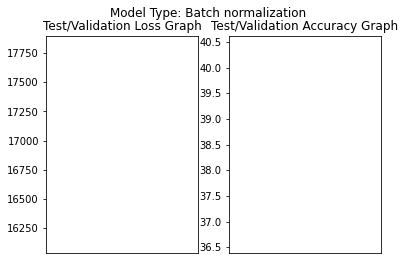

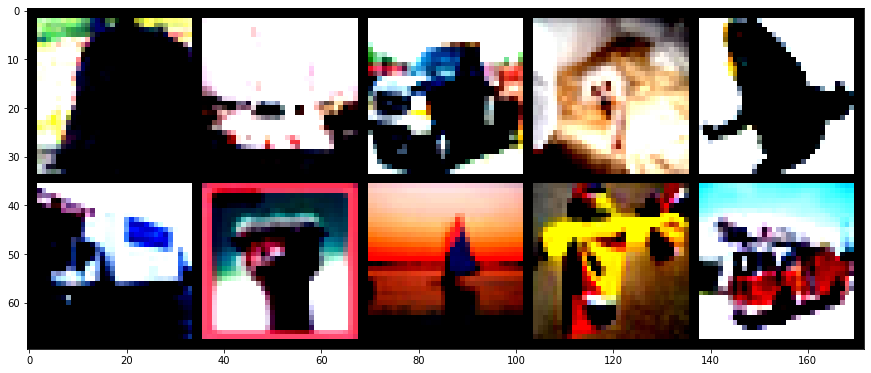

In [31]:
main(0,1)


In [ ]:
#

#test_10_images = torch.stack(test_10_images)
#print(test_10_images.dtype)
##print(test_10_images)
#grid = torchvision.utils.make_grid(torch.stack(test_fail_data), nrow=5)
#plt.figure(figsize=(15,15))
#plt.imshow(np.transpose(grid, (1,2,0)))